# **MLP with extended physics loss function simple baseline**
## y_phy calculated by linear time shifting according to wind speed and dist


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_Linear_MSE" # choose from "MSE" and "Physics_Linear_MSE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

### **Start hyperparameter searching with Optuna**

In [16]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_newvalloss", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-12 18:37:04,784] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_newvalloss
/tmp/ipykernel_14772/3588211214.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_14772/3588211214.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50
Epoch 1/50 - Train Loss: 0.057498 - Val Loss (DD rmse only): 0.253030
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031450 - Val Loss (DD rmse only): 0.209131
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029257 - Val Loss (DD rmse only): 0.226954
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028275 - Val Loss (DD rmse only): 0.207710
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026481 - Val Loss (DD rmse only): 0.209031
Epoch 6/50
Epoch 6/50 - Train Loss: 0.024124 - Val Loss (DD rmse only): 0.191513
Epoch 7/50
Epoch 7/50 - Train Loss: 0.020319 - Val Loss (DD rmse only): 0.163155
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018375 - Val Loss (DD rmse only): 0.155444
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017125 - Val Loss (DD rmse only): 0.156737
Epoch 10/50
Epoch 10/50 - Train Loss: 0.017258 - Val Loss (DD rmse only): 0.152558
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016496 - Val Loss (DD rmse only): 0.160905
Epoch 12/50
Epoch 12/50 - Train Loss: 0.016177 - Val Loss (DD rmse only): 0.151340
Epoch 13/50
Epoch 13/5

[I 2025-03-12 18:37:39,476] Trial 0 finished with value: 0.14231162269910178 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 103, 'lr': 0.0006756794635066747, 'weight_decay': 1.836695118777897e-05, 'batch_size': 8}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.014195 - Val Loss (DD rmse only): 0.144855
Epoch 1/50


/tmp/ipykernel_14772/3588211214.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_14772/3588211214.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.034124 - Val Loss (DD rmse only): 0.183880
Epoch 2/50
Epoch 2/50 - Train Loss: 0.018383 - Val Loss (DD rmse only): 0.156823
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016386 - Val Loss (DD rmse only): 0.153362
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015554 - Val Loss (DD rmse only): 0.145674
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015748 - Val Loss (DD rmse only): 0.146594
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015571 - Val Loss (DD rmse only): 0.145802
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014877 - Val Loss (DD rmse only): 0.144151
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014710 - Val Loss (DD rmse only): 0.143578
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015162 - Val Loss (DD rmse only): 0.145768
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016670 - Val Loss (DD rmse only): 0.149028
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015758 - Val Loss (DD rmse only): 0.149546
Epoch 12/50
Epoch 12/50 - Train Loss: 0.015249 - Val Loss (DD rmse only): 0.142328
Epoch 13/50
Epoch 13/50 - Train L

[I 2025-03-12 18:38:10,213] Trial 1 finished with value: 0.14232835670312247 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 143, 'lr': 0.007499640120782385, 'weight_decay': 2.1412243757571026e-08, 'batch_size': 8}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.012507 - Val Loss (DD rmse only): 0.182983
Epoch 1/50
Epoch 1/50 - Train Loss: 0.067462 - Val Loss (DD rmse only): 0.319907
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039971 - Val Loss (DD rmse only): 0.236477
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033842 - Val Loss (DD rmse only): 0.209238
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031748 - Val Loss (DD rmse only): 0.224325
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026482 - Val Loss (DD rmse only): 0.238940
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027303 - Val Loss (DD rmse only): 0.237610
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028074 - Val Loss (DD rmse only): 0.220667
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025928 - Val Loss (DD rmse only): 0.205495
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025566 - Val Loss (DD rmse only): 0.198046
Epoch 10/50
Epoch 10/50 - Train Loss: 0.023717 - Val Loss (DD rmse only): 0.196788
Epoch 11/50
Epoch 11/50 - Train Loss: 0.021361 - Val Loss (DD rmse only): 0.182773
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:38:28,673] Trial 2 finished with value: 0.142970472574234 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 145, 'lr': 0.0006971572429625183, 'weight_decay': 2.618345192430675e-08, 'batch_size': 32}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.013255 - Val Loss (DD rmse only): 0.150534
Epoch 1/50
Epoch 1/50 - Train Loss: 0.155645 - Val Loss (DD rmse only): 0.453674
Epoch 2/50
Epoch 2/50 - Train Loss: 0.114881 - Val Loss (DD rmse only): 0.402096
Epoch 3/50
Epoch 3/50 - Train Loss: 0.083144 - Val Loss (DD rmse only): 0.346857
Epoch 4/50
Epoch 4/50 - Train Loss: 0.056858 - Val Loss (DD rmse only): 0.291901
Epoch 5/50
Epoch 5/50 - Train Loss: 0.037404 - Val Loss (DD rmse only): 0.242240
Epoch 6/50
Epoch 6/50 - Train Loss: 0.030419 - Val Loss (DD rmse only): 0.215655
Epoch 7/50
Epoch 7/50 - Train Loss: 0.038005 - Val Loss (DD rmse only): 0.211474
Epoch 8/50
Epoch 8/50 - Train Loss: 0.042267 - Val Loss (DD rmse only): 0.209006
Epoch 9/50
Epoch 9/50 - Train Loss: 0.038379 - Val Loss (DD rmse only): 0.209702
Epoch 10/50
Epoch 10/50 - Train Loss: 0.031361 - Val Loss (DD rmse only): 0.218516
Epoch 11/50
Epoch 11/50 - Train Loss: 0.027852 - Val Loss (DD rmse only): 0.231532
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:38:39,151] Trial 3 finished with value: 0.1451338827610016 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 81, 'lr': 0.0013129394643645767, 'weight_decay': 2.0054601111524816e-08, 'batch_size': 64}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.014815 - Val Loss (DD rmse only): 0.145134
Epoch 1/50
Epoch 1/50 - Train Loss: 0.080669 - Val Loss (DD rmse only): 0.386819
Epoch 2/50
Epoch 2/50 - Train Loss: 0.078449 - Val Loss (DD rmse only): 0.376563
Epoch 3/50
Epoch 3/50 - Train Loss: 0.072899 - Val Loss (DD rmse only): 0.366439
Epoch 4/50
Epoch 4/50 - Train Loss: 0.064515 - Val Loss (DD rmse only): 0.356489
Epoch 5/50
Epoch 5/50 - Train Loss: 0.061790 - Val Loss (DD rmse only): 0.346778
Epoch 6/50
Epoch 6/50 - Train Loss: 0.054237 - Val Loss (DD rmse only): 0.337291
Epoch 7/50
Epoch 7/50 - Train Loss: 0.051215 - Val Loss (DD rmse only): 0.328124
Epoch 8/50
Epoch 8/50 - Train Loss: 0.047685 - Val Loss (DD rmse only): 0.319266
Epoch 9/50
Epoch 9/50 - Train Loss: 0.043665 - Val Loss (DD rmse only): 0.310763
Epoch 10/50
Epoch 10/50 - Train Loss: 0.042772 - Val Loss (DD rmse only): 0.302652
Epoch 11/50
Epoch 11/50 - Train Loss: 0.038652 - Val Loss (DD rmse only): 0.294890
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:38:50,795] Trial 4 finished with value: 0.20391800999641418 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 147, 'lr': 9.815192685733519e-05, 'weight_decay': 7.08164806201331e-06, 'batch_size': 64}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.020797 - Val Loss (DD rmse only): 0.203918
Epoch 1/50
Epoch 1/50 - Train Loss: 0.149377 - Val Loss (DD rmse only): 0.480039
Epoch 2/50
Epoch 2/50 - Train Loss: 0.146819 - Val Loss (DD rmse only): 0.476668
Epoch 3/50
Epoch 3/50 - Train Loss: 0.144270 - Val Loss (DD rmse only): 0.473193
Epoch 4/50
Epoch 4/50 - Train Loss: 0.141643 - Val Loss (DD rmse only): 0.469718
Epoch 5/50
Epoch 5/50 - Train Loss: 0.139036 - Val Loss (DD rmse only): 0.466175
Epoch 6/50
Epoch 6/50 - Train Loss: 0.136470 - Val Loss (DD rmse only): 0.462682
Epoch 7/50
Epoch 7/50 - Train Loss: 0.133966 - Val Loss (DD rmse only): 0.459260
Epoch 8/50
Epoch 8/50 - Train Loss: 0.131492 - Val Loss (DD rmse only): 0.455853
Epoch 9/50
Epoch 9/50 - Train Loss: 0.129040 - Val Loss (DD rmse only): 0.452398
Epoch 10/50
Epoch 10/50 - Train Loss: 0.126595 - Val Loss (DD rmse only): 0.448863
Epoch 11/50
Epoch 11/50 - Train Loss: 0.124090 - Val Loss (DD rmse only): 0.445227
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:40:23,005] Trial 5 finished with value: 0.2230584273735682 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 148, 'lr': 1.1620157636519109e-05, 'weight_decay': 5.878099150790295e-08, 'batch_size': 8}. Best is trial 0 with value: 0.14231162269910178.


Epoch 50/50 - Train Loss: 0.029171 - Val Loss (DD rmse only): 0.223058
Epoch 1/50
Epoch 1/50 - Train Loss: 0.064993 - Val Loss (DD rmse only): 0.202497
Epoch 2/50
Epoch 2/50 - Train Loss: 0.023670 - Val Loss (DD rmse only): 0.182316
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020789 - Val Loss (DD rmse only): 0.184866
Epoch 4/50
Epoch 4/50 - Train Loss: 0.020328 - Val Loss (DD rmse only): 0.165482
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017626 - Val Loss (DD rmse only): 0.160565
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016376 - Val Loss (DD rmse only): 0.156144
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016538 - Val Loss (DD rmse only): 0.158975
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015361 - Val Loss (DD rmse only): 0.151518
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015580 - Val Loss (DD rmse only): 0.146179
Epoch 10/50
Epoch 10/50 - Train Loss: 0.014630 - Val Loss (DD rmse only): 0.153619
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016345 - Val Loss (DD rmse only): 0.155987
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:40:47,701] Trial 6 finished with value: 0.14182832092046738 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 185, 'lr': 0.001950841137569128, 'weight_decay': 4.5370473777414546e-08, 'batch_size': 16}. Best is trial 6 with value: 0.14182832092046738.


Epoch 50/50 - Train Loss: 0.013042 - Val Loss (DD rmse only): 0.165839
Epoch 1/50
Epoch 1/50 - Train Loss: 0.124761 - Val Loss (DD rmse only): 0.456283
Epoch 2/50
Epoch 2/50 - Train Loss: 0.120745 - Val Loss (DD rmse only): 0.452295
Epoch 3/50
Epoch 3/50 - Train Loss: 0.125909 - Val Loss (DD rmse only): 0.448328
Epoch 4/50
Epoch 4/50 - Train Loss: 0.111194 - Val Loss (DD rmse only): 0.444381
Epoch 5/50
Epoch 5/50 - Train Loss: 0.110241 - Val Loss (DD rmse only): 0.440484
Epoch 6/50
Epoch 6/50 - Train Loss: 0.101867 - Val Loss (DD rmse only): 0.436643
Epoch 7/50
Epoch 7/50 - Train Loss: 0.112760 - Val Loss (DD rmse only): 0.432842
Epoch 8/50
Epoch 8/50 - Train Loss: 0.102224 - Val Loss (DD rmse only): 0.429023
Epoch 9/50
Epoch 9/50 - Train Loss: 0.100717 - Val Loss (DD rmse only): 0.425257
Epoch 10/50
Epoch 10/50 - Train Loss: 0.092567 - Val Loss (DD rmse only): 0.421541
Epoch 11/50
Epoch 11/50 - Train Loss: 0.093702 - Val Loss (DD rmse only): 0.417882
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:41:02,289] Trial 7 finished with value: 0.3011603057384491 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 184, 'lr': 1.324165697564972e-05, 'weight_decay': 5.973110493526922e-05, 'batch_size': 32}. Best is trial 6 with value: 0.14182832092046738.


Epoch 50/50 - Train Loss: 0.038373 - Val Loss (DD rmse only): 0.301160
Epoch 1/50
Epoch 1/50 - Train Loss: 0.126374 - Val Loss (DD rmse only): 0.384812
Epoch 2/50
Epoch 2/50 - Train Loss: 0.066470 - Val Loss (DD rmse only): 0.283751
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033162 - Val Loss (DD rmse only): 0.209426
Epoch 4/50
Epoch 4/50 - Train Loss: 0.046118 - Val Loss (DD rmse only): 0.205302
Epoch 5/50
Epoch 5/50 - Train Loss: 0.037169 - Val Loss (DD rmse only): 0.224147
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027944 - Val Loss (DD rmse only): 0.255416
Epoch 7/50
Epoch 7/50 - Train Loss: 0.030651 - Val Loss (DD rmse only): 0.267589
Epoch 8/50
Epoch 8/50 - Train Loss: 0.032520 - Val Loss (DD rmse only): 0.257616
Epoch 9/50
Epoch 9/50 - Train Loss: 0.030433 - Val Loss (DD rmse only): 0.232892
Epoch 10/50
Epoch 10/50 - Train Loss: 0.025699 - Val Loss (DD rmse only): 0.205655
Epoch 11/50
Epoch 11/50 - Train Loss: 0.025985 - Val Loss (DD rmse only): 0.192335
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:41:19,251] Trial 8 finished with value: 0.14164549112319946 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 241, 'lr': 0.0008282620015547203, 'weight_decay': 4.764296938693548e-05, 'batch_size': 64}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.014305 - Val Loss (DD rmse only): 0.142753
Epoch 1/50
Epoch 1/50 - Train Loss: 0.109356 - Val Loss (DD rmse only): 0.420109
Epoch 2/50
Epoch 2/50 - Train Loss: 0.107968 - Val Loss (DD rmse only): 0.416022
Epoch 3/50
Epoch 3/50 - Train Loss: 0.106756 - Val Loss (DD rmse only): 0.411951
Epoch 4/50
Epoch 4/50 - Train Loss: 0.102268 - Val Loss (DD rmse only): 0.407882
Epoch 5/50
Epoch 5/50 - Train Loss: 0.100654 - Val Loss (DD rmse only): 0.403853
Epoch 6/50
Epoch 6/50 - Train Loss: 0.099982 - Val Loss (DD rmse only): 0.399863
Epoch 7/50
Epoch 7/50 - Train Loss: 0.095631 - Val Loss (DD rmse only): 0.395868
Epoch 8/50
Epoch 8/50 - Train Loss: 0.091304 - Val Loss (DD rmse only): 0.391891
Epoch 9/50
Epoch 9/50 - Train Loss: 0.089875 - Val Loss (DD rmse only): 0.387993
Epoch 10/50
Epoch 10/50 - Train Loss: 0.089387 - Val Loss (DD rmse only): 0.384103
Epoch 11/50
Epoch 11/50 - Train Loss: 0.085379 - Val Loss (DD rmse only): 0.380206
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:41:33,390] Trial 9 finished with value: 0.24571146816015244 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 46, 'lr': 3.6091064649727436e-05, 'weight_decay': 2.608461594746753e-05, 'batch_size': 16}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.032481 - Val Loss (DD rmse only): 0.245711
Epoch 1/50
Epoch 1/50 - Train Loss: 0.094133 - Val Loss (DD rmse only): 0.397336
Epoch 2/50
Epoch 2/50 - Train Loss: 0.088761 - Val Loss (DD rmse only): 0.380525
Epoch 3/50
Epoch 3/50 - Train Loss: 0.072152 - Val Loss (DD rmse only): 0.363879
Epoch 4/50
Epoch 4/50 - Train Loss: 0.065234 - Val Loss (DD rmse only): 0.347542
Epoch 5/50
Epoch 5/50 - Train Loss: 0.057525 - Val Loss (DD rmse only): 0.331017
Epoch 6/50
Epoch 6/50 - Train Loss: 0.050154 - Val Loss (DD rmse only): 0.314225
Epoch 7/50
Epoch 7/50 - Train Loss: 0.043426 - Val Loss (DD rmse only): 0.297230
Epoch 8/50
Epoch 8/50 - Train Loss: 0.039193 - Val Loss (DD rmse only): 0.280331
Epoch 9/50
Epoch 9/50 - Train Loss: 0.035709 - Val Loss (DD rmse only): 0.264155
Epoch 10/50
Epoch 10/50 - Train Loss: 0.031302 - Val Loss (DD rmse only): 0.249411
Epoch 11/50
Epoch 11/50 - Train Loss: 0.031470 - Val Loss (DD rmse only): 0.237593
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:41:51,714] Trial 10 finished with value: 0.17505738139152527 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 241, 'lr': 0.0001506626651400638, 'weight_decay': 0.0009230255678561763, 'batch_size': 64}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.017001 - Val Loss (DD rmse only): 0.175057
Epoch 1/50
Epoch 1/50 - Train Loss: 0.061680 - Val Loss (DD rmse only): 0.248400
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027649 - Val Loss (DD rmse only): 0.201352
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020061 - Val Loss (DD rmse only): 0.164426
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018605 - Val Loss (DD rmse only): 0.183474
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017091 - Val Loss (DD rmse only): 0.151170
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015393 - Val Loss (DD rmse only): 0.147134
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014928 - Val Loss (DD rmse only): 0.144392
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014731 - Val Loss (DD rmse only): 0.142811
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014722 - Val Loss (DD rmse only): 0.143238
Epoch 10/50
Epoch 10/50 - Train Loss: 0.014450 - Val Loss (DD rmse only): 0.149279
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014833 - Val Loss (DD rmse only): 0.153756
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:42:25,152] Trial 11 finished with value: 0.1428108587861061 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 249, 'lr': 0.002887127903332695, 'weight_decay': 5.892155904954996e-07, 'batch_size': 16}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.013599 - Val Loss (DD rmse only): 0.176287
Epoch 1/50
Epoch 1/50 - Train Loss: 0.034698 - Val Loss (DD rmse only): 0.174331
Epoch 2/50
Epoch 2/50 - Train Loss: 0.019278 - Val Loss (DD rmse only): 0.163077
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016571 - Val Loss (DD rmse only): 0.155184
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015492 - Val Loss (DD rmse only): 0.143252
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016749 - Val Loss (DD rmse only): 0.153656
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016212 - Val Loss (DD rmse only): 0.147256
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014547 - Val Loss (DD rmse only): 0.145628
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015409 - Val Loss (DD rmse only): 0.143349
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014827 - Val Loss (DD rmse only): 0.147567
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015004 - Val Loss (DD rmse only): 0.145541
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014136 - Val Loss (DD rmse only): 0.145469
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:42:49,611] Trial 12 finished with value: 0.14325226098299026 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 213, 'lr': 0.004234063513106175, 'weight_decay': 7.827818867092288e-07, 'batch_size': 16}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.012364 - Val Loss (DD rmse only): 0.186312
Epoch 1/50
Epoch 1/50 - Train Loss: 0.073884 - Val Loss (DD rmse only): 0.191376
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035312 - Val Loss (DD rmse only): 0.240724
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028829 - Val Loss (DD rmse only): 0.181420
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024274 - Val Loss (DD rmse only): 0.196788
Epoch 5/50
Epoch 5/50 - Train Loss: 0.021314 - Val Loss (DD rmse only): 0.171240
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018480 - Val Loss (DD rmse only): 0.171166
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018849 - Val Loss (DD rmse only): 0.168495
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017031 - Val Loss (DD rmse only): 0.167579
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016823 - Val Loss (DD rmse only): 0.157404
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016501 - Val Loss (DD rmse only): 0.153608
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016155 - Val Loss (DD rmse only): 0.151927
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:43:23,977] Trial 13 finished with value: 0.1443721503019333 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 200, 'lr': 0.0016216756472595326, 'weight_decay': 0.0002070846774821972, 'batch_size': 16}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.015128 - Val Loss (DD rmse only): 0.149614
Epoch 1/50
Epoch 1/50 - Train Loss: 0.144614 - Val Loss (DD rmse only): 0.447425
Epoch 2/50
Epoch 2/50 - Train Loss: 0.111787 - Val Loss (DD rmse only): 0.407077
Epoch 3/50
Epoch 3/50 - Train Loss: 0.086680 - Val Loss (DD rmse only): 0.366567
Epoch 4/50
Epoch 4/50 - Train Loss: 0.066159 - Val Loss (DD rmse only): 0.325147
Epoch 5/50
Epoch 5/50 - Train Loss: 0.048972 - Val Loss (DD rmse only): 0.282820
Epoch 6/50
Epoch 6/50 - Train Loss: 0.036055 - Val Loss (DD rmse only): 0.244602
Epoch 7/50
Epoch 7/50 - Train Loss: 0.031128 - Val Loss (DD rmse only): 0.221131
Epoch 8/50
Epoch 8/50 - Train Loss: 0.034329 - Val Loss (DD rmse only): 0.213957
Epoch 9/50
Epoch 9/50 - Train Loss: 0.038547 - Val Loss (DD rmse only): 0.211986
Epoch 10/50
Epoch 10/50 - Train Loss: 0.037359 - Val Loss (DD rmse only): 0.212645
Epoch 11/50
Epoch 11/50 - Train Loss: 0.031814 - Val Loss (DD rmse only): 0.218191
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:43:40,064] Trial 14 finished with value: 0.15022499859333038 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 214, 'lr': 0.00031694706989430284, 'weight_decay': 3.4884408084415634e-07, 'batch_size': 64}. Best is trial 8 with value: 0.14164549112319946.


Epoch 50/50 - Train Loss: 0.014793 - Val Loss (DD rmse only): 0.150225
Epoch 1/50
Epoch 1/50 - Train Loss: 0.060619 - Val Loss (DD rmse only): 0.221231
Epoch 2/50
Epoch 2/50 - Train Loss: 0.032984 - Val Loss (DD rmse only): 0.187239
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027163 - Val Loss (DD rmse only): 0.209369
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025551 - Val Loss (DD rmse only): 0.201148
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022321 - Val Loss (DD rmse only): 0.177494
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022379 - Val Loss (DD rmse only): 0.178769
Epoch 7/50
Epoch 7/50 - Train Loss: 0.020236 - Val Loss (DD rmse only): 0.173561
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018291 - Val Loss (DD rmse only): 0.162365
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017515 - Val Loss (DD rmse only): 0.159192
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016270 - Val Loss (DD rmse only): 0.153221
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015476 - Val Loss (DD rmse only): 0.149728
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:44:03,545] Trial 15 finished with value: 0.14084292203187943 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 188, 'lr': 0.0004335537465239168, 'weight_decay': 2.89710107147184e-06, 'batch_size': 16}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.013051 - Val Loss (DD rmse only): 0.154499
Epoch 1/50
Epoch 1/50 - Train Loss: 0.095848 - Val Loss (DD rmse only): 0.397033
Epoch 2/50
Epoch 2/50 - Train Loss: 0.083709 - Val Loss (DD rmse only): 0.378533
Epoch 3/50
Epoch 3/50 - Train Loss: 0.075335 - Val Loss (DD rmse only): 0.359744
Epoch 4/50
Epoch 4/50 - Train Loss: 0.065291 - Val Loss (DD rmse only): 0.339339
Epoch 5/50
Epoch 5/50 - Train Loss: 0.051588 - Val Loss (DD rmse only): 0.316283
Epoch 6/50
Epoch 6/50 - Train Loss: 0.044432 - Val Loss (DD rmse only): 0.290681
Epoch 7/50
Epoch 7/50 - Train Loss: 0.036676 - Val Loss (DD rmse only): 0.263893
Epoch 8/50
Epoch 8/50 - Train Loss: 0.031342 - Val Loss (DD rmse only): 0.238526
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029592 - Val Loss (DD rmse only): 0.219857
Epoch 10/50
Epoch 10/50 - Train Loss: 0.030843 - Val Loss (DD rmse only): 0.211635
Epoch 11/50
Epoch 11/50 - Train Loss: 0.032656 - Val Loss (DD rmse only): 0.210145
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:44:23,984] Trial 16 finished with value: 0.1467011719942093 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 256, 'lr': 0.00022293559840653378, 'weight_decay': 2.413041909785649e-06, 'batch_size': 64}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.015267 - Val Loss (DD rmse only): 0.146701
Epoch 1/50
Epoch 1/50 - Train Loss: 0.098946 - Val Loss (DD rmse only): 0.323801
Epoch 2/50
Epoch 2/50 - Train Loss: 0.038454 - Val Loss (DD rmse only): 0.216488
Epoch 3/50
Epoch 3/50 - Train Loss: 0.040808 - Val Loss (DD rmse only): 0.206721
Epoch 4/50
Epoch 4/50 - Train Loss: 0.033509 - Val Loss (DD rmse only): 0.230049
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032571 - Val Loss (DD rmse only): 0.247958
Epoch 6/50
Epoch 6/50 - Train Loss: 0.032894 - Val Loss (DD rmse only): 0.235581
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025051 - Val Loss (DD rmse only): 0.209540
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025463 - Val Loss (DD rmse only): 0.196206
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027851 - Val Loss (DD rmse only): 0.194253
Epoch 10/50
Epoch 10/50 - Train Loss: 0.023665 - Val Loss (DD rmse only): 0.197886
Epoch 11/50
Epoch 11/50 - Train Loss: 0.024222 - Val Loss (DD rmse only): 0.191394
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:44:46,851] Trial 17 finished with value: 0.14174477756023407 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 227, 'lr': 0.0005070479117046343, 'weight_decay': 0.00014030179481191034, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014611 - Val Loss (DD rmse only): 0.143188
Epoch 1/50
Epoch 1/50 - Train Loss: 0.120153 - Val Loss (DD rmse only): 0.424259
Epoch 2/50
Epoch 2/50 - Train Loss: 0.098350 - Val Loss (DD rmse only): 0.397985
Epoch 3/50
Epoch 3/50 - Train Loss: 0.084710 - Val Loss (DD rmse only): 0.372767
Epoch 4/50
Epoch 4/50 - Train Loss: 0.071758 - Val Loss (DD rmse only): 0.348342
Epoch 5/50
Epoch 5/50 - Train Loss: 0.059730 - Val Loss (DD rmse only): 0.324381
Epoch 6/50
Epoch 6/50 - Train Loss: 0.051093 - Val Loss (DD rmse only): 0.301276
Epoch 7/50
Epoch 7/50 - Train Loss: 0.042915 - Val Loss (DD rmse only): 0.279619
Epoch 8/50
Epoch 8/50 - Train Loss: 0.036579 - Val Loss (DD rmse only): 0.259846
Epoch 9/50
Epoch 9/50 - Train Loss: 0.032170 - Val Loss (DD rmse only): 0.243768
Epoch 10/50
Epoch 10/50 - Train Loss: 0.030434 - Val Loss (DD rmse only): 0.231757
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028872 - Val Loss (DD rmse only): 0.223023
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:45:10,827] Trial 18 finished with value: 0.15103796124458313 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 178, 'lr': 5.3657102527289343e-05, 'weight_decay': 3.940491458332612e-06, 'batch_size': 16}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.015548 - Val Loss (DD rmse only): 0.151038
Epoch 1/50
Epoch 1/50 - Train Loss: 0.142022 - Val Loss (DD rmse only): 0.425130
Epoch 2/50
Epoch 2/50 - Train Loss: 0.095148 - Val Loss (DD rmse only): 0.349231
Epoch 3/50
Epoch 3/50 - Train Loss: 0.051724 - Val Loss (DD rmse only): 0.247500
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029328 - Val Loss (DD rmse only): 0.204838
Epoch 5/50
Epoch 5/50 - Train Loss: 0.045506 - Val Loss (DD rmse only): 0.201549
Epoch 6/50
Epoch 6/50 - Train Loss: 0.034257 - Val Loss (DD rmse only): 0.218116
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025830 - Val Loss (DD rmse only): 0.247891
Epoch 8/50
Epoch 8/50 - Train Loss: 0.032176 - Val Loss (DD rmse only): 0.263812
Epoch 9/50
Epoch 9/50 - Train Loss: 0.033439 - Val Loss (DD rmse only): 0.259000
Epoch 10/50
Epoch 10/50 - Train Loss: 0.031059 - Val Loss (DD rmse only): 0.240619
Epoch 11/50
Epoch 11/50 - Train Loss: 0.027790 - Val Loss (DD rmse only): 0.216956
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:45:26,336] Trial 19 finished with value: 0.14447839558124542 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 168, 'lr': 0.0009604109729804366, 'weight_decay': 0.0006822204516710209, 'batch_size': 64}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014789 - Val Loss (DD rmse only): 0.144478
Epoch 1/50
Epoch 1/50 - Train Loss: 0.119837 - Val Loss (DD rmse only): 0.406933
Epoch 2/50
Epoch 2/50 - Train Loss: 0.083976 - Val Loss (DD rmse only): 0.352079
Epoch 3/50
Epoch 3/50 - Train Loss: 0.054192 - Val Loss (DD rmse only): 0.305096
Epoch 4/50
Epoch 4/50 - Train Loss: 0.039878 - Val Loss (DD rmse only): 0.264913
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032750 - Val Loss (DD rmse only): 0.235782
Epoch 6/50
Epoch 6/50 - Train Loss: 0.032304 - Val Loss (DD rmse only): 0.221313
Epoch 7/50
Epoch 7/50 - Train Loss: 0.035638 - Val Loss (DD rmse only): 0.215599
Epoch 8/50
Epoch 8/50 - Train Loss: 0.035312 - Val Loss (DD rmse only): 0.213852
Epoch 9/50
Epoch 9/50 - Train Loss: 0.032414 - Val Loss (DD rmse only): 0.215982
Epoch 10/50
Epoch 10/50 - Train Loss: 0.029194 - Val Loss (DD rmse only): 0.221157
Epoch 11/50
Epoch 11/50 - Train Loss: 0.026148 - Val Loss (DD rmse only): 0.226192
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:45:39,603] Trial 20 finished with value: 0.1436222642660141 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 226, 'lr': 0.0003691171880253425, 'weight_decay': 1.6922627881979055e-07, 'batch_size': 64}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014161 - Val Loss (DD rmse only): 0.144240
Epoch 1/50
Epoch 1/50 - Train Loss: 0.127646 - Val Loss (DD rmse only): 0.398238
Epoch 2/50
Epoch 2/50 - Train Loss: 0.058765 - Val Loss (DD rmse only): 0.263066
Epoch 3/50
Epoch 3/50 - Train Loss: 0.034035 - Val Loss (DD rmse only): 0.209962
Epoch 4/50
Epoch 4/50 - Train Loss: 0.036066 - Val Loss (DD rmse only): 0.220093
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027816 - Val Loss (DD rmse only): 0.251083
Epoch 6/50
Epoch 6/50 - Train Loss: 0.031189 - Val Loss (DD rmse only): 0.243344
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026351 - Val Loss (DD rmse only): 0.211935
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025949 - Val Loss (DD rmse only): 0.193939
Epoch 9/50
Epoch 9/50 - Train Loss: 0.023169 - Val Loss (DD rmse only): 0.195617
Epoch 10/50
Epoch 10/50 - Train Loss: 0.022975 - Val Loss (DD rmse only): 0.203840
Epoch 11/50
Epoch 11/50 - Train Loss: 0.022005 - Val Loss (DD rmse only): 0.189333
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:46:01,526] Trial 21 finished with value: 0.1435127556324005 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 230, 'lr': 0.0005149126592504811, 'weight_decay': 0.00017366397059879983, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.015447 - Val Loss (DD rmse only): 0.144920
Epoch 1/50
Epoch 1/50 - Train Loss: 0.120365 - Val Loss (DD rmse only): 0.428968
Epoch 2/50
Epoch 2/50 - Train Loss: 0.098464 - Val Loss (DD rmse only): 0.388678
Epoch 3/50
Epoch 3/50 - Train Loss: 0.067911 - Val Loss (DD rmse only): 0.345921
Epoch 4/50
Epoch 4/50 - Train Loss: 0.048488 - Val Loss (DD rmse only): 0.301323
Epoch 5/50
Epoch 5/50 - Train Loss: 0.036756 - Val Loss (DD rmse only): 0.256897
Epoch 6/50
Epoch 6/50 - Train Loss: 0.031632 - Val Loss (DD rmse only): 0.224028
Epoch 7/50
Epoch 7/50 - Train Loss: 0.033611 - Val Loss (DD rmse only): 0.212145
Epoch 8/50
Epoch 8/50 - Train Loss: 0.032655 - Val Loss (DD rmse only): 0.212776
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029310 - Val Loss (DD rmse only): 0.218950
Epoch 10/50
Epoch 10/50 - Train Loss: 0.027899 - Val Loss (DD rmse only): 0.224481
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028740 - Val Loss (DD rmse only): 0.225321
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:46:21,950] Trial 22 finished with value: 0.14487454295158386 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 204, 'lr': 0.00019221034810349246, 'weight_decay': 8.53886037932311e-05, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.013955 - Val Loss (DD rmse only): 0.144875
Epoch 1/50
Epoch 1/50 - Train Loss: 0.119508 - Val Loss (DD rmse only): 0.417258
Epoch 2/50
Epoch 2/50 - Train Loss: 0.092388 - Val Loss (DD rmse only): 0.391037
Epoch 3/50
Epoch 3/50 - Train Loss: 0.080133 - Val Loss (DD rmse only): 0.364369
Epoch 4/50
Epoch 4/50 - Train Loss: 0.058850 - Val Loss (DD rmse only): 0.336603
Epoch 5/50
Epoch 5/50 - Train Loss: 0.053708 - Val Loss (DD rmse only): 0.308154
Epoch 6/50
Epoch 6/50 - Train Loss: 0.040808 - Val Loss (DD rmse only): 0.279479
Epoch 7/50
Epoch 7/50 - Train Loss: 0.032382 - Val Loss (DD rmse only): 0.252120
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030930 - Val Loss (DD rmse only): 0.230651
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028066 - Val Loss (DD rmse only): 0.217499
Epoch 10/50
Epoch 10/50 - Train Loss: 0.027438 - Val Loss (DD rmse only): 0.212537
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028526 - Val Loss (DD rmse only): 0.212480
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:46:44,010] Trial 23 finished with value: 0.145204097032547 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 229, 'lr': 0.00010848145558838075, 'weight_decay': 1.4827713337316835e-05, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014486 - Val Loss (DD rmse only): 0.145204
Epoch 1/50
Epoch 1/50 - Train Loss: 0.126852 - Val Loss (DD rmse only): 0.412484
Epoch 2/50
Epoch 2/50 - Train Loss: 0.081036 - Val Loss (DD rmse only): 0.323509
Epoch 3/50
Epoch 3/50 - Train Loss: 0.040796 - Val Loss (DD rmse only): 0.220853
Epoch 4/50
Epoch 4/50 - Train Loss: 0.035257 - Val Loss (DD rmse only): 0.202314
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032481 - Val Loss (DD rmse only): 0.208835
Epoch 6/50
Epoch 6/50 - Train Loss: 0.031286 - Val Loss (DD rmse only): 0.229874
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026515 - Val Loss (DD rmse only): 0.227582
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024226 - Val Loss (DD rmse only): 0.210538
Epoch 9/50
Epoch 9/50 - Train Loss: 0.024354 - Val Loss (DD rmse only): 0.196960
Epoch 10/50
Epoch 10/50 - Train Loss: 0.024578 - Val Loss (DD rmse only): 0.192899
Epoch 11/50
Epoch 11/50 - Train Loss: 0.023491 - Val Loss (DD rmse only): 0.190720
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:47:07,865] Trial 24 finished with value: 0.1413876712322235 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 195, 'lr': 0.0004299637254313597, 'weight_decay': 0.0002871384519303311, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.013916 - Val Loss (DD rmse only): 0.142506
Epoch 1/50
Epoch 1/50 - Train Loss: 0.141212 - Val Loss (DD rmse only): 0.431519
Epoch 2/50
Epoch 2/50 - Train Loss: 0.087765 - Val Loss (DD rmse only): 0.336041
Epoch 3/50
Epoch 3/50 - Train Loss: 0.042926 - Val Loss (DD rmse only): 0.232046
Epoch 4/50
Epoch 4/50 - Train Loss: 0.033632 - Val Loss (DD rmse only): 0.205348
Epoch 5/50
Epoch 5/50 - Train Loss: 0.034686 - Val Loss (DD rmse only): 0.215533
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026803 - Val Loss (DD rmse only): 0.235545
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026927 - Val Loss (DD rmse only): 0.237704
Epoch 8/50
Epoch 8/50 - Train Loss: 0.029276 - Val Loss (DD rmse only): 0.221825
Epoch 9/50
Epoch 9/50 - Train Loss: 0.024119 - Val Loss (DD rmse only): 0.197454
Epoch 10/50
Epoch 10/50 - Train Loss: 0.027102 - Val Loss (DD rmse only): 0.187094
Epoch 11/50
Epoch 11/50 - Train Loss: 0.022501 - Val Loss (DD rmse only): 0.192696
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:47:26,170] Trial 25 finished with value: 0.14245323836803436 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 113, 'lr': 0.0009410708849424372, 'weight_decay': 0.00032192071261422263, 'batch_size': 32}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.015480 - Val Loss (DD rmse only): 0.143347
Epoch 1/50
Epoch 1/50 - Train Loss: 0.048950 - Val Loss (DD rmse only): 0.249931
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034008 - Val Loss (DD rmse only): 0.218662
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030101 - Val Loss (DD rmse only): 0.202850
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028015 - Val Loss (DD rmse only): 0.217969
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026016 - Val Loss (DD rmse only): 0.178260
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019888 - Val Loss (DD rmse only): 0.165139
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018592 - Val Loss (DD rmse only): 0.163642
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017487 - Val Loss (DD rmse only): 0.153538
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015546 - Val Loss (DD rmse only): 0.153925
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015949 - Val Loss (DD rmse only): 0.154451
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017229 - Val Loss (DD rmse only): 0.145685
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:48:02,248] Trial 26 finished with value: 0.1438533142209053 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 164, 'lr': 0.0030117153711580074, 'weight_decay': 4.3636917576492415e-05, 'batch_size': 16}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014549 - Val Loss (DD rmse only): 0.150398
Epoch 1/50
Epoch 1/50 - Train Loss: 0.120081 - Val Loss (DD rmse only): 0.352603
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039174 - Val Loss (DD rmse only): 0.194783
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029566 - Val Loss (DD rmse only): 0.232281
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026474 - Val Loss (DD rmse only): 0.189890
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022830 - Val Loss (DD rmse only): 0.188579
Epoch 6/50
Epoch 6/50 - Train Loss: 0.020240 - Val Loss (DD rmse only): 0.171541
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018355 - Val Loss (DD rmse only): 0.167885
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016845 - Val Loss (DD rmse only): 0.159225
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016819 - Val Loss (DD rmse only): 0.154620
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016455 - Val Loss (DD rmse only): 0.151385
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015445 - Val Loss (DD rmse only): 0.149068
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:48:56,816] Trial 27 finished with value: 0.14298343161741892 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 202, 'lr': 0.00029703976925170175, 'weight_decay': 7.935554460933664e-06, 'batch_size': 8}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.013035 - Val Loss (DD rmse only): 0.149564
Epoch 1/50
Epoch 1/50 - Train Loss: 0.169040 - Val Loss (DD rmse only): 0.500983
Epoch 2/50
Epoch 2/50 - Train Loss: 0.157561 - Val Loss (DD rmse only): 0.490030
Epoch 3/50
Epoch 3/50 - Train Loss: 0.152094 - Val Loss (DD rmse only): 0.478591
Epoch 4/50
Epoch 4/50 - Train Loss: 0.144435 - Val Loss (DD rmse only): 0.466363
Epoch 5/50
Epoch 5/50 - Train Loss: 0.133590 - Val Loss (DD rmse only): 0.452574
Epoch 6/50
Epoch 6/50 - Train Loss: 0.124305 - Val Loss (DD rmse only): 0.437216
Epoch 7/50
Epoch 7/50 - Train Loss: 0.113474 - Val Loss (DD rmse only): 0.419899
Epoch 8/50
Epoch 8/50 - Train Loss: 0.101615 - Val Loss (DD rmse only): 0.400119
Epoch 9/50
Epoch 9/50 - Train Loss: 0.090045 - Val Loss (DD rmse only): 0.377107
Epoch 10/50
Epoch 10/50 - Train Loss: 0.075450 - Val Loss (DD rmse only): 0.350554
Epoch 11/50
Epoch 11/50 - Train Loss: 0.060370 - Val Loss (DD rmse only): 0.321157
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:49:36,666] Trial 28 finished with value: 0.16400381177663803 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 189, 'lr': 4.494195500389599e-05, 'weight_decay': 1.353241377819275e-06, 'batch_size': 16}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.016072 - Val Loss (DD rmse only): 0.164004
Epoch 1/50
Epoch 1/50 - Train Loss: 0.049622 - Val Loss (DD rmse only): 0.198770
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029318 - Val Loss (DD rmse only): 0.226859
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025909 - Val Loss (DD rmse only): 0.188870
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021571 - Val Loss (DD rmse only): 0.167558
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018809 - Val Loss (DD rmse only): 0.156083
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017526 - Val Loss (DD rmse only): 0.160918
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015969 - Val Loss (DD rmse only): 0.151119
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015509 - Val Loss (DD rmse only): 0.145704
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015383 - Val Loss (DD rmse only): 0.146810
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015308 - Val Loss (DD rmse only): 0.144805
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015733 - Val Loss (DD rmse only): 0.144603
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:50:38,629] Trial 29 finished with value: 0.14112543563048044 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 167, 'lr': 0.0007654505592186309, 'weight_decay': 2.142048596457221e-05, 'batch_size': 8}. Best is trial 15 with value: 0.14084292203187943.


Epoch 50/50 - Train Loss: 0.014424 - Val Loss (DD rmse only): 0.155409
Epoch 1/50
Epoch 1/50 - Train Loss: 0.071018 - Val Loss (DD rmse only): 0.292180
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033818 - Val Loss (DD rmse only): 0.204467
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030051 - Val Loss (DD rmse only): 0.225930
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028057 - Val Loss (DD rmse only): 0.209212
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027876 - Val Loss (DD rmse only): 0.213422
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026131 - Val Loss (DD rmse only): 0.197918
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024522 - Val Loss (DD rmse only): 0.190272
Epoch 8/50
Epoch 8/50 - Train Loss: 0.021835 - Val Loss (DD rmse only): 0.186685
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020013 - Val Loss (DD rmse only): 0.180668
Epoch 10/50
Epoch 10/50 - Train Loss: 0.018699 - Val Loss (DD rmse only): 0.160942
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016698 - Val Loss (DD rmse only): 0.153694
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:51:15,543] Trial 30 finished with value: 0.14073761800924936 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 124, 'lr': 0.0004932323530456757, 'weight_decay': 1.6702716837594655e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.014145 - Val Loss (DD rmse only): 0.147391
Epoch 1/50
Epoch 1/50 - Train Loss: 0.061835 - Val Loss (DD rmse only): 0.280511
Epoch 2/50
Epoch 2/50 - Train Loss: 0.032884 - Val Loss (DD rmse only): 0.202715
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028460 - Val Loss (DD rmse only): 0.221456
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027691 - Val Loss (DD rmse only): 0.200105
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025520 - Val Loss (DD rmse only): 0.200730
Epoch 6/50
Epoch 6/50 - Train Loss: 0.023133 - Val Loss (DD rmse only): 0.175902
Epoch 7/50
Epoch 7/50 - Train Loss: 0.020673 - Val Loss (DD rmse only): 0.167289
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017980 - Val Loss (DD rmse only): 0.159124
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017646 - Val Loss (DD rmse only): 0.156026
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016705 - Val Loss (DD rmse only): 0.156808
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016082 - Val Loss (DD rmse only): 0.153626
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:51:52,347] Trial 31 finished with value: 0.1435404121875763 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 112, 'lr': 0.0004891686136592471, 'weight_decay': 9.235209404751587e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013842 - Val Loss (DD rmse only): 0.162634
Epoch 1/50
Epoch 1/50 - Train Loss: 0.070055 - Val Loss (DD rmse only): 0.202997
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029047 - Val Loss (DD rmse only): 0.254732
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031356 - Val Loss (DD rmse only): 0.202366
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026218 - Val Loss (DD rmse only): 0.209039
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022405 - Val Loss (DD rmse only): 0.168995
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019317 - Val Loss (DD rmse only): 0.166103
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016775 - Val Loss (DD rmse only): 0.154155
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016128 - Val Loss (DD rmse only): 0.151355
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015606 - Val Loss (DD rmse only): 0.149014
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015823 - Val Loss (DD rmse only): 0.149578
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015563 - Val Loss (DD rmse only): 0.150118
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:52:26,981] Trial 32 finished with value: 0.14354812602202097 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 126, 'lr': 0.0011421109295151326, 'weight_decay': 2.0482313610098236e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013805 - Val Loss (DD rmse only): 0.155721
Epoch 1/50
Epoch 1/50 - Train Loss: 0.070011 - Val Loss (DD rmse only): 0.206731
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031333 - Val Loss (DD rmse only): 0.237531
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027192 - Val Loss (DD rmse only): 0.200864
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025747 - Val Loss (DD rmse only): 0.194848
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022784 - Val Loss (DD rmse only): 0.192803
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019307 - Val Loss (DD rmse only): 0.169219
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016488 - Val Loss (DD rmse only): 0.156271
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015939 - Val Loss (DD rmse only): 0.151012
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016162 - Val Loss (DD rmse only): 0.149474
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015125 - Val Loss (DD rmse only): 0.156458
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016514 - Val Loss (DD rmse only): 0.159236
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:53:05,975] Trial 33 finished with value: 0.14489774405956268 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 164, 'lr': 0.0006204252237646521, 'weight_decay': 2.5669948108754295e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013712 - Val Loss (DD rmse only): 0.153298
Epoch 1/50
Epoch 1/50 - Train Loss: 0.064787 - Val Loss (DD rmse only): 0.305097
Epoch 2/50
Epoch 2/50 - Train Loss: 0.037043 - Val Loss (DD rmse only): 0.236830
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029004 - Val Loss (DD rmse only): 0.206616
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028553 - Val Loss (DD rmse only): 0.217216
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028644 - Val Loss (DD rmse only): 0.223688
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027698 - Val Loss (DD rmse only): 0.211228
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027364 - Val Loss (DD rmse only): 0.206600
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026581 - Val Loss (DD rmse only): 0.211444
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025362 - Val Loss (DD rmse only): 0.195884
Epoch 10/50
Epoch 10/50 - Train Loss: 0.023655 - Val Loss (DD rmse only): 0.191565
Epoch 11/50
Epoch 11/50 - Train Loss: 0.021328 - Val Loss (DD rmse only): 0.174766
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:53:35,246] Trial 34 finished with value: 0.1421202669541041 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 81, 'lr': 0.00037529785402893684, 'weight_decay': 0.00042523432972266055, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.015036 - Val Loss (DD rmse only): 0.143180
Epoch 1/50
Epoch 1/50 - Train Loss: 0.069181 - Val Loss (DD rmse only): 0.325234
Epoch 2/50
Epoch 2/50 - Train Loss: 0.047489 - Val Loss (DD rmse only): 0.271642
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031385 - Val Loss (DD rmse only): 0.217419
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029599 - Val Loss (DD rmse only): 0.210744
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027590 - Val Loss (DD rmse only): 0.218290
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027424 - Val Loss (DD rmse only): 0.213936
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026429 - Val Loss (DD rmse only): 0.203971
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024669 - Val Loss (DD rmse only): 0.197968
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022225 - Val Loss (DD rmse only): 0.183168
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019378 - Val Loss (DD rmse only): 0.165335
Epoch 11/50
Epoch 11/50 - Train Loss: 0.018071 - Val Loss (DD rmse only): 0.159664
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:54:11,945] Trial 35 finished with value: 0.14268471797307333 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 130, 'lr': 0.0002163242803053108, 'weight_decay': 2.9672250656356328e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.014034 - Val Loss (DD rmse only): 0.143231
Epoch 1/50
Epoch 1/50 - Train Loss: 0.036086 - Val Loss (DD rmse only): 0.219163
Epoch 2/50
Epoch 2/50 - Train Loss: 0.025349 - Val Loss (DD rmse only): 0.174568
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020291 - Val Loss (DD rmse only): 0.170623
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018674 - Val Loss (DD rmse only): 0.152401
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018162 - Val Loss (DD rmse only): 0.148442
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016329 - Val Loss (DD rmse only): 0.153911
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016524 - Val Loss (DD rmse only): 0.147296
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016137 - Val Loss (DD rmse only): 0.146951
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015696 - Val Loss (DD rmse only): 0.153826
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015410 - Val Loss (DD rmse only): 0.149278
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015813 - Val Loss (DD rmse only): 0.153042
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:54:38,047] Trial 36 finished with value: 0.14401216308275858 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 88, 'lr': 0.0056920689588228724, 'weight_decay': 5.290112191135019e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.012384 - Val Loss (DD rmse only): 0.172205
Epoch 1/50
Epoch 1/50 - Train Loss: 0.057875 - Val Loss (DD rmse only): 0.262864
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029524 - Val Loss (DD rmse only): 0.204507
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026473 - Val Loss (DD rmse only): 0.194411
Epoch 4/50
Epoch 4/50 - Train Loss: 0.020641 - Val Loss (DD rmse only): 0.162828
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018668 - Val Loss (DD rmse only): 0.161798
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015912 - Val Loss (DD rmse only): 0.141350
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016262 - Val Loss (DD rmse only): 0.144695
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016717 - Val Loss (DD rmse only): 0.175831
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016885 - Val Loss (DD rmse only): 0.151810
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015410 - Val Loss (DD rmse only): 0.152208
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016128 - Val Loss (DD rmse only): 0.142446
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:55:17,036] Trial 37 finished with value: 0.14135009547074637 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 153, 'lr': 0.0018640027043272276, 'weight_decay': 1.1771224526570465e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013156 - Val Loss (DD rmse only): 0.156449
Epoch 1/50
Epoch 1/50 - Train Loss: 0.039308 - Val Loss (DD rmse only): 0.222570
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027391 - Val Loss (DD rmse only): 0.210672
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020180 - Val Loss (DD rmse only): 0.156224
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018412 - Val Loss (DD rmse only): 0.151471
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017163 - Val Loss (DD rmse only): 0.170688
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017929 - Val Loss (DD rmse only): 0.146855
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016063 - Val Loss (DD rmse only): 0.146511
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015142 - Val Loss (DD rmse only): 0.149708
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014943 - Val Loss (DD rmse only): 0.147353
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015230 - Val Loss (DD rmse only): 0.155281
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015614 - Val Loss (DD rmse only): 0.147749
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:56:02,280] Trial 38 finished with value: 0.1439228355884552 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 154, 'lr': 0.0025101537852131733, 'weight_decay': 1.548737835056369e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.012350 - Val Loss (DD rmse only): 0.171934
Epoch 1/50
Epoch 1/50 - Train Loss: 0.074681 - Val Loss (DD rmse only): 0.250838
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030058 - Val Loss (DD rmse only): 0.197264
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026693 - Val Loss (DD rmse only): 0.202985
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023352 - Val Loss (DD rmse only): 0.171152
Epoch 5/50
Epoch 5/50 - Train Loss: 0.020289 - Val Loss (DD rmse only): 0.160765
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017305 - Val Loss (DD rmse only): 0.148997
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016018 - Val Loss (DD rmse only): 0.144067
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015304 - Val Loss (DD rmse only): 0.144158
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015248 - Val Loss (DD rmse only): 0.141923
Epoch 10/50
Epoch 10/50 - Train Loss: 0.014952 - Val Loss (DD rmse only): 0.144613
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015671 - Val Loss (DD rmse only): 0.150545
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:56:43,141] Trial 39 finished with value: 0.141922856370608 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 135, 'lr': 0.0016330318196792649, 'weight_decay': 9.793933003491681e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013037 - Val Loss (DD rmse only): 0.169805
Epoch 1/50
Epoch 1/50 - Train Loss: 0.050630 - Val Loss (DD rmse only): 0.182590
Epoch 2/50
Epoch 2/50 - Train Loss: 0.022161 - Val Loss (DD rmse only): 0.166988
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016806 - Val Loss (DD rmse only): 0.159461
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016103 - Val Loss (DD rmse only): 0.151223
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015452 - Val Loss (DD rmse only): 0.148726
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015402 - Val Loss (DD rmse only): 0.145970
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015161 - Val Loss (DD rmse only): 0.143584
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015193 - Val Loss (DD rmse only): 0.144362
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015084 - Val Loss (DD rmse only): 0.147169
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015645 - Val Loss (DD rmse only): 0.152803
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015551 - Val Loss (DD rmse only): 0.144907
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:57:05,007] Trial 40 finished with value: 0.14186241726080576 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 60, 'lr': 0.00869164174631107, 'weight_decay': 1.334865631826853e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.014815 - Val Loss (DD rmse only): 0.153375
Epoch 1/50
Epoch 1/50 - Train Loss: 0.073172 - Val Loss (DD rmse only): 0.194549
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030831 - Val Loss (DD rmse only): 0.221815
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027545 - Val Loss (DD rmse only): 0.206765
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024995 - Val Loss (DD rmse only): 0.196102
Epoch 5/50
Epoch 5/50 - Train Loss: 0.020734 - Val Loss (DD rmse only): 0.161861
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017894 - Val Loss (DD rmse only): 0.155705
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017307 - Val Loss (DD rmse only): 0.155104
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016933 - Val Loss (DD rmse only): 0.162162
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015715 - Val Loss (DD rmse only): 0.149041
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015311 - Val Loss (DD rmse only): 0.145773
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015249 - Val Loss (DD rmse only): 0.148386
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:58:10,911] Trial 41 finished with value: 0.14468072851498923 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 157, 'lr': 0.0006980423805237828, 'weight_decay': 7.997333306098656e-05, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013873 - Val Loss (DD rmse only): 0.156910
Epoch 1/50
Epoch 1/50 - Train Loss: 0.093434 - Val Loss (DD rmse only): 0.204601
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031362 - Val Loss (DD rmse only): 0.226222
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025987 - Val Loss (DD rmse only): 0.187760
Epoch 4/50
Epoch 4/50 - Train Loss: 0.022208 - Val Loss (DD rmse only): 0.169269
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019223 - Val Loss (DD rmse only): 0.161017
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017415 - Val Loss (DD rmse only): 0.153740
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016727 - Val Loss (DD rmse only): 0.151509
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016598 - Val Loss (DD rmse only): 0.146414
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015691 - Val Loss (DD rmse only): 0.145443
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015203 - Val Loss (DD rmse only): 0.143431
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015549 - Val Loss (DD rmse only): 0.145375
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:59:14,720] Trial 42 finished with value: 0.14185194174448648 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 174, 'lr': 0.0007958411113913587, 'weight_decay': 3.4268206208129325e-06, 'batch_size': 8}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.012721 - Val Loss (DD rmse only): 0.151929
Epoch 1/50
Epoch 1/50 - Train Loss: 0.104739 - Val Loss (DD rmse only): 0.362869
Epoch 2/50
Epoch 2/50 - Train Loss: 0.045434 - Val Loss (DD rmse only): 0.218663
Epoch 3/50
Epoch 3/50 - Train Loss: 0.034337 - Val Loss (DD rmse only): 0.209380
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027820 - Val Loss (DD rmse only): 0.249336
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032621 - Val Loss (DD rmse only): 0.245374
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028219 - Val Loss (DD rmse only): 0.212311
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028531 - Val Loss (DD rmse only): 0.197485
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024860 - Val Loss (DD rmse only): 0.212610
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026354 - Val Loss (DD rmse only): 0.212176
Epoch 10/50
Epoch 10/50 - Train Loss: 0.025865 - Val Loss (DD rmse only): 0.188197
Epoch 11/50
Epoch 11/50 - Train Loss: 0.020761 - Val Loss (DD rmse only): 0.183114
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 18:59:37,478] Trial 43 finished with value: 0.1476205736398697 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 142, 'lr': 0.00119151899859715, 'weight_decay': 3.194249697909796e-05, 'batch_size': 32}. Best is trial 30 with value: 0.14073761800924936.


Epoch 50/50 - Train Loss: 0.013599 - Val Loss (DD rmse only): 0.153272
Epoch 1/50
Epoch 1/50 - Train Loss: 0.080375 - Val Loss (DD rmse only): 0.339248
Epoch 2/50
Epoch 2/50 - Train Loss: 0.049891 - Val Loss (DD rmse only): 0.267251
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031362 - Val Loss (DD rmse only): 0.210472
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028251 - Val Loss (DD rmse only): 0.208586
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026765 - Val Loss (DD rmse only): 0.210107
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025776 - Val Loss (DD rmse only): 0.205211
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024200 - Val Loss (DD rmse only): 0.195794
Epoch 8/50
Epoch 8/50 - Train Loss: 0.022546 - Val Loss (DD rmse only): 0.185603
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020820 - Val Loss (DD rmse only): 0.175562
Epoch 10/50
Epoch 10/50 - Train Loss: 0.018724 - Val Loss (DD rmse only): 0.167148
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017236 - Val Loss (DD rmse only): 0.156591
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:00:28,835] Trial 44 finished with value: 0.14004295070966086 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 184, 'lr': 0.00013022485650778092, 'weight_decay': 1.762147613805231e-06, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013414 - Val Loss (DD rmse only): 0.147424
Epoch 1/50
Epoch 1/50 - Train Loss: 0.178607 - Val Loss (DD rmse only): 0.503129
Epoch 2/50
Epoch 2/50 - Train Loss: 0.155045 - Val Loss (DD rmse only): 0.472779
Epoch 3/50
Epoch 3/50 - Train Loss: 0.130526 - Val Loss (DD rmse only): 0.436637
Epoch 4/50
Epoch 4/50 - Train Loss: 0.102380 - Val Loss (DD rmse only): 0.386641
Epoch 5/50
Epoch 5/50 - Train Loss: 0.070204 - Val Loss (DD rmse only): 0.315416
Epoch 6/50
Epoch 6/50 - Train Loss: 0.040072 - Val Loss (DD rmse only): 0.237129
Epoch 7/50
Epoch 7/50 - Train Loss: 0.031168 - Val Loss (DD rmse only): 0.219976
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030926 - Val Loss (DD rmse only): 0.226220
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029915 - Val Loss (DD rmse only): 0.226601
Epoch 10/50
Epoch 10/50 - Train Loss: 0.029240 - Val Loss (DD rmse only): 0.217859
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028715 - Val Loss (DD rmse only): 0.214310
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:01:22,799] Trial 45 finished with value: 0.14291327695051828 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 145, 'lr': 9.12541237556612e-05, 'weight_decay': 1.8543498359723674e-06, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014954 - Val Loss (DD rmse only): 0.142913
Epoch 1/50
Epoch 1/50 - Train Loss: 0.113225 - Val Loss (DD rmse only): 0.402647
Epoch 2/50
Epoch 2/50 - Train Loss: 0.081721 - Val Loss (DD rmse only): 0.342963
Epoch 3/50
Epoch 3/50 - Train Loss: 0.047887 - Val Loss (DD rmse only): 0.250269
Epoch 4/50
Epoch 4/50 - Train Loss: 0.030569 - Val Loss (DD rmse only): 0.201869
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028626 - Val Loss (DD rmse only): 0.217653
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026914 - Val Loss (DD rmse only): 0.205069
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025569 - Val Loss (DD rmse only): 0.199985
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024254 - Val Loss (DD rmse only): 0.194761
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022758 - Val Loss (DD rmse only): 0.187704
Epoch 10/50
Epoch 10/50 - Train Loss: 0.020910 - Val Loss (DD rmse only): 0.174104
Epoch 11/50
Epoch 11/50 - Train Loss: 0.019347 - Val Loss (DD rmse only): 0.168283
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:02:24,211] Trial 46 finished with value: 0.1420548011859258 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 182, 'lr': 0.00012109670495201485, 'weight_decay': 2.3422697309800505e-07, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014040 - Val Loss (DD rmse only): 0.146240
Epoch 1/50
Epoch 1/50 - Train Loss: 0.054690 - Val Loss (DD rmse only): 0.227425
Epoch 2/50
Epoch 2/50 - Train Loss: 0.025885 - Val Loss (DD rmse only): 0.180685
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020150 - Val Loss (DD rmse only): 0.161968
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016990 - Val Loss (DD rmse only): 0.156743
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015938 - Val Loss (DD rmse only): 0.152845
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015431 - Val Loss (DD rmse only): 0.150274
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015077 - Val Loss (DD rmse only): 0.143924
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014667 - Val Loss (DD rmse only): 0.144081
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015168 - Val Loss (DD rmse only): 0.145720
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015293 - Val Loss (DD rmse only): 0.155138
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014235 - Val Loss (DD rmse only): 0.147100
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:02:45,879] Trial 47 finished with value: 0.14392443497975668 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 122, 'lr': 0.002122518230468237, 'weight_decay': 5.351917415226848e-06, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.012367 - Val Loss (DD rmse only): 0.162903
Epoch 1/50
Epoch 1/50 - Train Loss: 0.217045 - Val Loss (DD rmse only): 0.533877
Epoch 2/50
Epoch 2/50 - Train Loss: 0.159782 - Val Loss (DD rmse only): 0.471272
Epoch 3/50
Epoch 3/50 - Train Loss: 0.114618 - Val Loss (DD rmse only): 0.413371
Epoch 4/50
Epoch 4/50 - Train Loss: 0.080932 - Val Loss (DD rmse only): 0.361016
Epoch 5/50
Epoch 5/50 - Train Loss: 0.057350 - Val Loss (DD rmse only): 0.314499
Epoch 6/50
Epoch 6/50 - Train Loss: 0.042364 - Val Loss (DD rmse only): 0.275891
Epoch 7/50
Epoch 7/50 - Train Loss: 0.033433 - Val Loss (DD rmse only): 0.250146
Epoch 8/50
Epoch 8/50 - Train Loss: 0.029930 - Val Loss (DD rmse only): 0.232434
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028197 - Val Loss (DD rmse only): 0.221582
Epoch 10/50
Epoch 10/50 - Train Loss: 0.027038 - Val Loss (DD rmse only): 0.215914
Epoch 11/50
Epoch 11/50 - Train Loss: 0.026082 - Val Loss (DD rmse only): 0.211291
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:03:12,355] Trial 48 finished with value: 0.14542731642723083 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 157, 'lr': 6.968220015192749e-05, 'weight_decay': 1.2325968960552246e-05, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014984 - Val Loss (DD rmse only): 0.145427
Epoch 1/50
Epoch 1/50 - Train Loss: 0.091510 - Val Loss (DD rmse only): 0.371661
Epoch 2/50
Epoch 2/50 - Train Loss: 0.070396 - Val Loss (DD rmse only): 0.333142
Epoch 3/50
Epoch 3/50 - Train Loss: 0.054098 - Val Loss (DD rmse only): 0.287854
Epoch 4/50
Epoch 4/50 - Train Loss: 0.038384 - Val Loss (DD rmse only): 0.235642
Epoch 5/50
Epoch 5/50 - Train Loss: 0.030209 - Val Loss (DD rmse only): 0.201466
Epoch 6/50
Epoch 6/50 - Train Loss: 0.030298 - Val Loss (DD rmse only): 0.200532
Epoch 7/50
Epoch 7/50 - Train Loss: 0.029076 - Val Loss (DD rmse only): 0.209830
Epoch 8/50
Epoch 8/50 - Train Loss: 0.027915 - Val Loss (DD rmse only): 0.213225
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026782 - Val Loss (DD rmse only): 0.204818
Epoch 10/50
Epoch 10/50 - Train Loss: 0.026135 - Val Loss (DD rmse only): 0.196606
Epoch 11/50
Epoch 11/50 - Train Loss: 0.025510 - Val Loss (DD rmse only): 0.196647
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:03:42,979] Trial 49 finished with value: 0.14306914806365967 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 172, 'lr': 0.00015856175819519024, 'weight_decay': 5.632004744765957e-07, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014129 - Val Loss (DD rmse only): 0.145561
Epoch 1/50
Epoch 1/50 - Train Loss: 0.172560 - Val Loss (DD rmse only): 0.508860
Epoch 2/50
Epoch 2/50 - Train Loss: 0.168998 - Val Loss (DD rmse only): 0.504495
Epoch 3/50
Epoch 3/50 - Train Loss: 0.165438 - Val Loss (DD rmse only): 0.500250
Epoch 4/50
Epoch 4/50 - Train Loss: 0.162058 - Val Loss (DD rmse only): 0.496086
Epoch 5/50
Epoch 5/50 - Train Loss: 0.158792 - Val Loss (DD rmse only): 0.491979
Epoch 6/50
Epoch 6/50 - Train Loss: 0.155561 - Val Loss (DD rmse only): 0.487874
Epoch 7/50
Epoch 7/50 - Train Loss: 0.152313 - Val Loss (DD rmse only): 0.483547
Epoch 8/50
Epoch 8/50 - Train Loss: 0.148955 - Val Loss (DD rmse only): 0.479224
Epoch 9/50
Epoch 9/50 - Train Loss: 0.145666 - Val Loss (DD rmse only): 0.474927
Epoch 10/50
Epoch 10/50 - Train Loss: 0.142408 - Val Loss (DD rmse only): 0.470675
Epoch 11/50
Epoch 11/50 - Train Loss: 0.139326 - Val Loss (DD rmse only): 0.466160
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:04:14,717] Trial 50 finished with value: 0.21952072282632193 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 96, 'lr': 1.8241750664925843e-05, 'weight_decay': 9.180644852872224e-07, 'batch_size': 8}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.028232 - Val Loss (DD rmse only): 0.219521
Epoch 1/50
Epoch 1/50 - Train Loss: 0.109532 - Val Loss (DD rmse only): 0.408156
Epoch 2/50
Epoch 2/50 - Train Loss: 0.091264 - Val Loss (DD rmse only): 0.363257
Epoch 3/50
Epoch 3/50 - Train Loss: 0.058900 - Val Loss (DD rmse only): 0.310957
Epoch 4/50
Epoch 4/50 - Train Loss: 0.038712 - Val Loss (DD rmse only): 0.252766
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029343 - Val Loss (DD rmse only): 0.215396
Epoch 6/50
Epoch 6/50 - Train Loss: 0.035520 - Val Loss (DD rmse only): 0.211444
Epoch 7/50
Epoch 7/50 - Train Loss: 0.031080 - Val Loss (DD rmse only): 0.225562
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030320 - Val Loss (DD rmse only): 0.241735
Epoch 9/50
Epoch 9/50 - Train Loss: 0.031671 - Val Loss (DD rmse only): 0.243064
Epoch 10/50
Epoch 10/50 - Train Loss: 0.029805 - Val Loss (DD rmse only): 0.230776
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028160 - Val Loss (DD rmse only): 0.213997
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:04:42,138] Trial 51 finished with value: 0.14487525820732117 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 211, 'lr': 0.000276617980081748, 'weight_decay': 4.428112770149152e-06, 'batch_size': 32}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013369 - Val Loss (DD rmse only): 0.146615
Epoch 1/50
Epoch 1/50 - Train Loss: 0.091507 - Val Loss (DD rmse only): 0.317703
Epoch 2/50
Epoch 2/50 - Train Loss: 0.038923 - Val Loss (DD rmse only): 0.194033
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031781 - Val Loss (DD rmse only): 0.216065
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032003 - Val Loss (DD rmse only): 0.235702
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027436 - Val Loss (DD rmse only): 0.194616
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025903 - Val Loss (DD rmse only): 0.191474
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023610 - Val Loss (DD rmse only): 0.189958
Epoch 8/50
Epoch 8/50 - Train Loss: 0.022090 - Val Loss (DD rmse only): 0.176631
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020484 - Val Loss (DD rmse only): 0.168542
Epoch 10/50
Epoch 10/50 - Train Loss: 0.018596 - Val Loss (DD rmse only): 0.162601
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017784 - Val Loss (DD rmse only): 0.160528
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:05:14,882] Trial 52 finished with value: 0.1403324231505394 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 191, 'lr': 0.0005207743378764189, 'weight_decay': 6.44728542188089e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013457 - Val Loss (DD rmse only): 0.144000
Epoch 1/50
Epoch 1/50 - Train Loss: 0.070571 - Val Loss (DD rmse only): 0.191619
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031191 - Val Loss (DD rmse only): 0.230132
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029053 - Val Loss (DD rmse only): 0.194450
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026762 - Val Loss (DD rmse only): 0.203508
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023956 - Val Loss (DD rmse only): 0.170660
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019918 - Val Loss (DD rmse only): 0.161423
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017701 - Val Loss (DD rmse only): 0.156838
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017317 - Val Loss (DD rmse only): 0.162041
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016229 - Val Loss (DD rmse only): 0.150305
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015867 - Val Loss (DD rmse only): 0.147408
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015340 - Val Loss (DD rmse only): 0.146249
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:05:51,174] Trial 53 finished with value: 0.14404262602329254 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 189, 'lr': 0.0014327783431071356, 'weight_decay': 0.00010056826384502997, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013368 - Val Loss (DD rmse only): 0.153230
Epoch 1/50
Epoch 1/50 - Train Loss: 0.113886 - Val Loss (DD rmse only): 0.351150
Epoch 2/50
Epoch 2/50 - Train Loss: 0.045476 - Val Loss (DD rmse only): 0.200155
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033706 - Val Loss (DD rmse only): 0.202808
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028338 - Val Loss (DD rmse only): 0.224282
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026948 - Val Loss (DD rmse only): 0.198330
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025018 - Val Loss (DD rmse only): 0.186319
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023290 - Val Loss (DD rmse only): 0.182958
Epoch 8/50
Epoch 8/50 - Train Loss: 0.021066 - Val Loss (DD rmse only): 0.173510
Epoch 9/50
Epoch 9/50 - Train Loss: 0.019698 - Val Loss (DD rmse only): 0.167161
Epoch 10/50
Epoch 10/50 - Train Loss: 0.018023 - Val Loss (DD rmse only): 0.164571
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017040 - Val Loss (DD rmse only): 0.159509
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:06:19,873] Trial 54 finished with value: 0.14008762687444687 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 138, 'lr': 0.0006023234456453093, 'weight_decay': 1.9872343633462172e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014016 - Val Loss (DD rmse only): 0.140299
Epoch 1/50
Epoch 1/50 - Train Loss: 0.064853 - Val Loss (DD rmse only): 0.253815
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033226 - Val Loss (DD rmse only): 0.191293
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028574 - Val Loss (DD rmse only): 0.221534
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028260 - Val Loss (DD rmse only): 0.213884
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026863 - Val Loss (DD rmse only): 0.190855
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025539 - Val Loss (DD rmse only): 0.189184
Epoch 7/50
Epoch 7/50 - Train Loss: 0.022472 - Val Loss (DD rmse only): 0.175798
Epoch 8/50
Epoch 8/50 - Train Loss: 0.020190 - Val Loss (DD rmse only): 0.165871
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017831 - Val Loss (DD rmse only): 0.162146
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016796 - Val Loss (DD rmse only): 0.152539
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015837 - Val Loss (DD rmse only): 0.173496
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:06:48,588] Trial 55 finished with value: 0.1429775208234787 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 139, 'lr': 0.0006805233733376468, 'weight_decay': 4.155114272543872e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013347 - Val Loss (DD rmse only): 0.153934
Epoch 1/50
Epoch 1/50 - Train Loss: 0.121060 - Val Loss (DD rmse only): 0.391955
Epoch 2/50
Epoch 2/50 - Train Loss: 0.071167 - Val Loss (DD rmse only): 0.297407
Epoch 3/50
Epoch 3/50 - Train Loss: 0.037109 - Val Loss (DD rmse only): 0.212746
Epoch 4/50
Epoch 4/50 - Train Loss: 0.033224 - Val Loss (DD rmse only): 0.193292
Epoch 5/50
Epoch 5/50 - Train Loss: 0.033554 - Val Loss (DD rmse only): 0.202722
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028246 - Val Loss (DD rmse only): 0.214928
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026561 - Val Loss (DD rmse only): 0.202001
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025316 - Val Loss (DD rmse only): 0.192295
Epoch 9/50
Epoch 9/50 - Train Loss: 0.024360 - Val Loss (DD rmse only): 0.182390
Epoch 10/50
Epoch 10/50 - Train Loss: 0.021466 - Val Loss (DD rmse only): 0.183219
Epoch 11/50
Epoch 11/50 - Train Loss: 0.021466 - Val Loss (DD rmse only): 0.175977
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:07:15,237] Trial 56 finished with value: 0.14525719732046127 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 179, 'lr': 0.0002616919777359765, 'weight_decay': 1.876566327651574e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014090 - Val Loss (DD rmse only): 0.148955
Epoch 1/50
Epoch 1/50 - Train Loss: 0.054820 - Val Loss (DD rmse only): 0.213279
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029882 - Val Loss (DD rmse only): 0.202625
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027817 - Val Loss (DD rmse only): 0.211462
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025519 - Val Loss (DD rmse only): 0.187510
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022855 - Val Loss (DD rmse only): 0.185423
Epoch 6/50
Epoch 6/50 - Train Loss: 0.020159 - Val Loss (DD rmse only): 0.172669
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017744 - Val Loss (DD rmse only): 0.158147
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017028 - Val Loss (DD rmse only): 0.156807
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016279 - Val Loss (DD rmse only): 0.150043
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015214 - Val Loss (DD rmse only): 0.148407
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015108 - Val Loss (DD rmse only): 0.142817
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:07:47,528] Trial 57 finished with value: 0.14105064421892166 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 195, 'lr': 0.0005668882116704378, 'weight_decay': 6.104803595556624e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013265 - Val Loss (DD rmse only): 0.153799
Epoch 1/50
Epoch 1/50 - Train Loss: 0.062492 - Val Loss (DD rmse only): 0.200481
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030873 - Val Loss (DD rmse only): 0.199722
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025650 - Val Loss (DD rmse only): 0.193488
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021949 - Val Loss (DD rmse only): 0.172981
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019399 - Val Loss (DD rmse only): 0.168389
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018890 - Val Loss (DD rmse only): 0.160298
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016699 - Val Loss (DD rmse only): 0.157537
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015812 - Val Loss (DD rmse only): 0.150112
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015981 - Val Loss (DD rmse only): 0.148633
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015068 - Val Loss (DD rmse only): 0.143194
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014864 - Val Loss (DD rmse only): 0.141719
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:08:15,946] Trial 58 finished with value: 0.14119195193052292 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 219, 'lr': 0.0005569074808158025, 'weight_decay': 7.069674353177923e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013302 - Val Loss (DD rmse only): 0.162370
Epoch 1/50
Epoch 1/50 - Train Loss: 0.094470 - Val Loss (DD rmse only): 0.352144
Epoch 2/50
Epoch 2/50 - Train Loss: 0.051270 - Val Loss (DD rmse only): 0.248314
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030288 - Val Loss (DD rmse only): 0.194307
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031128 - Val Loss (DD rmse only): 0.210976
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027862 - Val Loss (DD rmse only): 0.219964
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026938 - Val Loss (DD rmse only): 0.206246
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025453 - Val Loss (DD rmse only): 0.185621
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023489 - Val Loss (DD rmse only): 0.193478
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022073 - Val Loss (DD rmse only): 0.179972
Epoch 10/50
Epoch 10/50 - Train Loss: 0.020579 - Val Loss (DD rmse only): 0.167438
Epoch 11/50
Epoch 11/50 - Train Loss: 0.018724 - Val Loss (DD rmse only): 0.163143
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:08:49,680] Trial 59 finished with value: 0.14109892398118973 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 199, 'lr': 0.0003439609940414243, 'weight_decay': 0.00012142718795273066, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013381 - Val Loss (DD rmse only): 0.146625
Epoch 1/50
Epoch 1/50 - Train Loss: 0.075669 - Val Loss (DD rmse only): 0.348451
Epoch 2/50
Epoch 2/50 - Train Loss: 0.061628 - Val Loss (DD rmse only): 0.315017
Epoch 3/50
Epoch 3/50 - Train Loss: 0.046097 - Val Loss (DD rmse only): 0.280407
Epoch 4/50
Epoch 4/50 - Train Loss: 0.037812 - Val Loss (DD rmse only): 0.240082
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028841 - Val Loss (DD rmse only): 0.204992
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028943 - Val Loss (DD rmse only): 0.197658
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028211 - Val Loss (DD rmse only): 0.203863
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026012 - Val Loss (DD rmse only): 0.209260
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025697 - Val Loss (DD rmse only): 0.203930
Epoch 10/50
Epoch 10/50 - Train Loss: 0.024306 - Val Loss (DD rmse only): 0.194327
Epoch 11/50
Epoch 11/50 - Train Loss: 0.023180 - Val Loss (DD rmse only): 0.190821
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:09:21,442] Trial 60 finished with value: 0.145332969725132 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 193, 'lr': 0.00016643263048093392, 'weight_decay': 4.860033315481685e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014179 - Val Loss (DD rmse only): 0.150993
Epoch 1/50
Epoch 1/50 - Train Loss: 0.129253 - Val Loss (DD rmse only): 0.388077
Epoch 2/50
Epoch 2/50 - Train Loss: 0.061702 - Val Loss (DD rmse only): 0.227865
Epoch 3/50
Epoch 3/50 - Train Loss: 0.034271 - Val Loss (DD rmse only): 0.194195
Epoch 4/50
Epoch 4/50 - Train Loss: 0.030593 - Val Loss (DD rmse only): 0.226578
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029040 - Val Loss (DD rmse only): 0.205801
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025704 - Val Loss (DD rmse only): 0.186312
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023887 - Val Loss (DD rmse only): 0.191698
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023590 - Val Loss (DD rmse only): 0.181623
Epoch 9/50
Epoch 9/50 - Train Loss: 0.021859 - Val Loss (DD rmse only): 0.173960
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019739 - Val Loss (DD rmse only): 0.173533
Epoch 11/50
Epoch 11/50 - Train Loss: 0.019817 - Val Loss (DD rmse only): 0.168266
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:09:54,742] Trial 61 finished with value: 0.1436910554766655 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 209, 'lr': 0.0003507469692347734, 'weight_decay': 0.00013217555523955716, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013869 - Val Loss (DD rmse only): 0.148220
Epoch 1/50
Epoch 1/50 - Train Loss: 0.094842 - Val Loss (DD rmse only): 0.313563
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033331 - Val Loss (DD rmse only): 0.192495
Epoch 3/50
Epoch 3/50 - Train Loss: 0.038785 - Val Loss (DD rmse only): 0.201164
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028705 - Val Loss (DD rmse only): 0.234953
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028499 - Val Loss (DD rmse only): 0.212596
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026391 - Val Loss (DD rmse only): 0.191183
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024382 - Val Loss (DD rmse only): 0.191665
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023464 - Val Loss (DD rmse only): 0.205409
Epoch 9/50
Epoch 9/50 - Train Loss: 0.021310 - Val Loss (DD rmse only): 0.178159
Epoch 10/50
Epoch 10/50 - Train Loss: 0.021116 - Val Loss (DD rmse only): 0.178619
Epoch 11/50
Epoch 11/50 - Train Loss: 0.020073 - Val Loss (DD rmse only): 0.174689
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:10:27,962] Trial 62 finished with value: 0.1461244449019432 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 200, 'lr': 0.00043435678571337246, 'weight_decay': 5.7565835463873195e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013088 - Val Loss (DD rmse only): 0.158567
Epoch 1/50
Epoch 1/50 - Train Loss: 0.066293 - Val Loss (DD rmse only): 0.211562
Epoch 2/50
Epoch 2/50 - Train Loss: 0.036592 - Val Loss (DD rmse only): 0.269252
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031858 - Val Loss (DD rmse only): 0.189539
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028525 - Val Loss (DD rmse only): 0.201191
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025842 - Val Loss (DD rmse only): 0.190877
Epoch 6/50
Epoch 6/50 - Train Loss: 0.021025 - Val Loss (DD rmse only): 0.170709
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019114 - Val Loss (DD rmse only): 0.166188
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017205 - Val Loss (DD rmse only): 0.159956
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016759 - Val Loss (DD rmse only): 0.164445
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016888 - Val Loss (DD rmse only): 0.152329
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015884 - Val Loss (DD rmse only): 0.150242
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:11:04,538] Trial 63 finished with value: 0.14302684366703033 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 218, 'lr': 0.0009583540214803513, 'weight_decay': 0.0002160338104453431, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014438 - Val Loss (DD rmse only): 0.150491
Epoch 1/50
Epoch 1/50 - Train Loss: 0.104669 - Val Loss (DD rmse only): 0.364401
Epoch 2/50
Epoch 2/50 - Train Loss: 0.058709 - Val Loss (DD rmse only): 0.267942
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030798 - Val Loss (DD rmse only): 0.198263
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032011 - Val Loss (DD rmse only): 0.195572
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027585 - Val Loss (DD rmse only): 0.212497
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025428 - Val Loss (DD rmse only): 0.202838
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023360 - Val Loss (DD rmse only): 0.188768
Epoch 8/50
Epoch 8/50 - Train Loss: 0.022702 - Val Loss (DD rmse only): 0.181747
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020395 - Val Loss (DD rmse only): 0.182334
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019404 - Val Loss (DD rmse only): 0.168998
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017814 - Val Loss (DD rmse only): 0.165166
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:11:35,835] Trial 64 finished with value: 0.14369846880435944 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 240, 'lr': 0.00022487165975245996, 'weight_decay': 0.0001317841029624226, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013829 - Val Loss (DD rmse only): 0.145490
Epoch 1/50
Epoch 1/50 - Train Loss: 0.122026 - Val Loss (DD rmse only): 0.415984
Epoch 2/50
Epoch 2/50 - Train Loss: 0.092963 - Val Loss (DD rmse only): 0.366078
Epoch 3/50
Epoch 3/50 - Train Loss: 0.062907 - Val Loss (DD rmse only): 0.302013
Epoch 4/50
Epoch 4/50 - Train Loss: 0.037975 - Val Loss (DD rmse only): 0.221984
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032319 - Val Loss (DD rmse only): 0.203607
Epoch 6/50
Epoch 6/50 - Train Loss: 0.031067 - Val Loss (DD rmse only): 0.223977
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028484 - Val Loss (DD rmse only): 0.220328
Epoch 8/50
Epoch 8/50 - Train Loss: 0.028688 - Val Loss (DD rmse only): 0.211869
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026944 - Val Loss (DD rmse only): 0.204955
Epoch 10/50
Epoch 10/50 - Train Loss: 0.026405 - Val Loss (DD rmse only): 0.203012
Epoch 11/50
Epoch 11/50 - Train Loss: 0.025368 - Val Loss (DD rmse only): 0.203414
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:12:02,644] Trial 65 finished with value: 0.14599120616912842 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 119, 'lr': 0.00039266425389035143, 'weight_decay': 5.9717993818101145e-06, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014882 - Val Loss (DD rmse only): 0.154978
Epoch 1/50
Epoch 1/50 - Train Loss: 0.104103 - Val Loss (DD rmse only): 0.358382
Epoch 2/50
Epoch 2/50 - Train Loss: 0.051729 - Val Loss (DD rmse only): 0.230428
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033480 - Val Loss (DD rmse only): 0.202758
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031943 - Val Loss (DD rmse only): 0.233205
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028360 - Val Loss (DD rmse only): 0.208183
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027289 - Val Loss (DD rmse only): 0.201489
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025191 - Val Loss (DD rmse only): 0.200936
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023715 - Val Loss (DD rmse only): 0.189331
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022202 - Val Loss (DD rmse only): 0.178853
Epoch 10/50
Epoch 10/50 - Train Loss: 0.020314 - Val Loss (DD rmse only): 0.174264
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017543 - Val Loss (DD rmse only): 0.164864
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:12:33,773] Trial 66 finished with value: 0.14365672320127487 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 185, 'lr': 0.0004961070304004298, 'weight_decay': 0.000498512771879744, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014496 - Val Loss (DD rmse only): 0.146532
Epoch 1/50
Epoch 1/50 - Train Loss: 0.126842 - Val Loss (DD rmse only): 0.363945
Epoch 2/50
Epoch 2/50 - Train Loss: 0.055431 - Val Loss (DD rmse only): 0.232396
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031530 - Val Loss (DD rmse only): 0.192986
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031293 - Val Loss (DD rmse only): 0.189087
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024894 - Val Loss (DD rmse only): 0.202231
Epoch 6/50
Epoch 6/50 - Train Loss: 0.024478 - Val Loss (DD rmse only): 0.197707
Epoch 7/50
Epoch 7/50 - Train Loss: 0.022386 - Val Loss (DD rmse only): 0.178769
Epoch 8/50
Epoch 8/50 - Train Loss: 0.021719 - Val Loss (DD rmse only): 0.173155
Epoch 9/50
Epoch 9/50 - Train Loss: 0.019216 - Val Loss (DD rmse only): 0.173428
Epoch 10/50
Epoch 10/50 - Train Loss: 0.018247 - Val Loss (DD rmse only): 0.166308
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017372 - Val Loss (DD rmse only): 0.162061
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:12:56,329] Trial 67 finished with value: 0.14672738313674927 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 194, 'lr': 0.00031184684648549293, 'weight_decay': 8.131049108689601e-08, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013837 - Val Loss (DD rmse only): 0.152468
Epoch 1/50
Epoch 1/50 - Train Loss: 0.116566 - Val Loss (DD rmse only): 0.331509
Epoch 2/50
Epoch 2/50 - Train Loss: 0.040324 - Val Loss (DD rmse only): 0.193500
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033348 - Val Loss (DD rmse only): 0.245846
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028636 - Val Loss (DD rmse only): 0.206024
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025301 - Val Loss (DD rmse only): 0.190430
Epoch 6/50
Epoch 6/50 - Train Loss: 0.023547 - Val Loss (DD rmse only): 0.197329
Epoch 7/50
Epoch 7/50 - Train Loss: 0.022054 - Val Loss (DD rmse only): 0.177954
Epoch 8/50
Epoch 8/50 - Train Loss: 0.019415 - Val Loss (DD rmse only): 0.174539
Epoch 9/50
Epoch 9/50 - Train Loss: 0.018410 - Val Loss (DD rmse only): 0.163459
Epoch 10/50
Epoch 10/50 - Train Loss: 0.017508 - Val Loss (DD rmse only): 0.159548
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016010 - Val Loss (DD rmse only): 0.155702
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:13:29,630] Trial 68 finished with value: 0.1435939073562622 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 205, 'lr': 0.0006082787820287118, 'weight_decay': 2.7702342980166793e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013588 - Val Loss (DD rmse only): 0.151593
Epoch 1/50
Epoch 1/50 - Train Loss: 0.133540 - Val Loss (DD rmse only): 0.462711
Epoch 2/50
Epoch 2/50 - Train Loss: 0.127562 - Val Loss (DD rmse only): 0.454342
Epoch 3/50
Epoch 3/50 - Train Loss: 0.125177 - Val Loss (DD rmse only): 0.446020
Epoch 4/50
Epoch 4/50 - Train Loss: 0.116314 - Val Loss (DD rmse only): 0.437773
Epoch 5/50
Epoch 5/50 - Train Loss: 0.110197 - Val Loss (DD rmse only): 0.429681
Epoch 6/50
Epoch 6/50 - Train Loss: 0.103775 - Val Loss (DD rmse only): 0.421732
Epoch 7/50
Epoch 7/50 - Train Loss: 0.101991 - Val Loss (DD rmse only): 0.413906
Epoch 8/50
Epoch 8/50 - Train Loss: 0.096507 - Val Loss (DD rmse only): 0.406179
Epoch 9/50
Epoch 9/50 - Train Loss: 0.092942 - Val Loss (DD rmse only): 0.398458
Epoch 10/50
Epoch 10/50 - Train Loss: 0.084743 - Val Loss (DD rmse only): 0.390677
Epoch 11/50
Epoch 11/50 - Train Loss: 0.083080 - Val Loss (DD rmse only): 0.382849
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:13:40,344] Trial 69 finished with value: 0.2199426144361496 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 112, 'lr': 0.00013579055075463322, 'weight_decay': 1.9051940948948936e-06, 'batch_size': 64}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.025378 - Val Loss (DD rmse only): 0.219943
Epoch 1/50
Epoch 1/50 - Train Loss: 0.151105 - Val Loss (DD rmse only): 0.474555
Epoch 2/50
Epoch 2/50 - Train Loss: 0.138362 - Val Loss (DD rmse only): 0.460820
Epoch 3/50
Epoch 3/50 - Train Loss: 0.128840 - Val Loss (DD rmse only): 0.447532
Epoch 4/50
Epoch 4/50 - Train Loss: 0.122510 - Val Loss (DD rmse only): 0.434180
Epoch 5/50
Epoch 5/50 - Train Loss: 0.113259 - Val Loss (DD rmse only): 0.420296
Epoch 6/50
Epoch 6/50 - Train Loss: 0.101890 - Val Loss (DD rmse only): 0.405131
Epoch 7/50
Epoch 7/50 - Train Loss: 0.094421 - Val Loss (DD rmse only): 0.388238
Epoch 8/50
Epoch 8/50 - Train Loss: 0.084992 - Val Loss (DD rmse only): 0.369620
Epoch 9/50
Epoch 9/50 - Train Loss: 0.073434 - Val Loss (DD rmse only): 0.349276
Epoch 10/50
Epoch 10/50 - Train Loss: 0.064158 - Val Loss (DD rmse only): 0.329396
Epoch 11/50
Epoch 11/50 - Train Loss: 0.056683 - Val Loss (DD rmse only): 0.310508
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:14:05,146] Trial 70 finished with value: 0.1747148185968399 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 104, 'lr': 8.610747140694676e-05, 'weight_decay': 3.773276136813173e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.019358 - Val Loss (DD rmse only): 0.174715
Epoch 1/50
Epoch 1/50 - Train Loss: 0.051729 - Val Loss (DD rmse only): 0.199003
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031933 - Val Loss (DD rmse only): 0.209956
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030167 - Val Loss (DD rmse only): 0.228306
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027769 - Val Loss (DD rmse only): 0.192263
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025717 - Val Loss (DD rmse only): 0.199539
Epoch 6/50
Epoch 6/50 - Train Loss: 0.023570 - Val Loss (DD rmse only): 0.183232
Epoch 7/50
Epoch 7/50 - Train Loss: 0.020139 - Val Loss (DD rmse only): 0.169533
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017837 - Val Loss (DD rmse only): 0.160027
Epoch 9/50
Epoch 9/50 - Train Loss: 0.018053 - Val Loss (DD rmse only): 0.172850
Epoch 10/50
Epoch 10/50 - Train Loss: 0.017880 - Val Loss (DD rmse only): 0.153626
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016219 - Val Loss (DD rmse only): 0.153757
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:14:35,167] Trial 71 finished with value: 0.14386191219091415 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 168, 'lr': 0.000932153679170572, 'weight_decay': 1.7689419548168704e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014894 - Val Loss (DD rmse only): 0.155289
Epoch 1/50
Epoch 1/50 - Train Loss: 0.052104 - Val Loss (DD rmse only): 0.194639
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034667 - Val Loss (DD rmse only): 0.219842
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029650 - Val Loss (DD rmse only): 0.221895
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025882 - Val Loss (DD rmse only): 0.180271
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023081 - Val Loss (DD rmse only): 0.183338
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019702 - Val Loss (DD rmse only): 0.166199
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017744 - Val Loss (DD rmse only): 0.160710
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016990 - Val Loss (DD rmse only): 0.155856
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015879 - Val Loss (DD rmse only): 0.152184
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015879 - Val Loss (DD rmse only): 0.154397
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014935 - Val Loss (DD rmse only): 0.146838
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:15:03,968] Trial 72 finished with value: 0.14192555099725723 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 178, 'lr': 0.0007419450961583926, 'weight_decay': 0.00010414684011731483, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013080 - Val Loss (DD rmse only): 0.152492
Epoch 1/50
Epoch 1/50 - Train Loss: 0.066309 - Val Loss (DD rmse only): 0.205199
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034549 - Val Loss (DD rmse only): 0.190227
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026265 - Val Loss (DD rmse only): 0.206973
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023481 - Val Loss (DD rmse only): 0.176198
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019991 - Val Loss (DD rmse only): 0.169396
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018371 - Val Loss (DD rmse only): 0.165086
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017345 - Val Loss (DD rmse only): 0.162890
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016258 - Val Loss (DD rmse only): 0.158068
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016477 - Val Loss (DD rmse only): 0.156479
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015819 - Val Loss (DD rmse only): 0.151557
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015296 - Val Loss (DD rmse only): 0.147926
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:15:26,614] Trial 73 finished with value: 0.14322128891944885 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 198, 'lr': 0.00047280800396730296, 'weight_decay': 2.141776755827766e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013163 - Val Loss (DD rmse only): 0.163300
Epoch 1/50
Epoch 1/50 - Train Loss: 0.143268 - Val Loss (DD rmse only): 0.468912
Epoch 2/50
Epoch 2/50 - Train Loss: 0.131817 - Val Loss (DD rmse only): 0.450363
Epoch 3/50
Epoch 3/50 - Train Loss: 0.112774 - Val Loss (DD rmse only): 0.430835
Epoch 4/50
Epoch 4/50 - Train Loss: 0.101987 - Val Loss (DD rmse only): 0.410426
Epoch 5/50
Epoch 5/50 - Train Loss: 0.092491 - Val Loss (DD rmse only): 0.388218
Epoch 6/50
Epoch 6/50 - Train Loss: 0.079793 - Val Loss (DD rmse only): 0.364615
Epoch 7/50
Epoch 7/50 - Train Loss: 0.067125 - Val Loss (DD rmse only): 0.339434
Epoch 8/50
Epoch 8/50 - Train Loss: 0.055430 - Val Loss (DD rmse only): 0.311591
Epoch 9/50
Epoch 9/50 - Train Loss: 0.043218 - Val Loss (DD rmse only): 0.281113
Epoch 10/50
Epoch 10/50 - Train Loss: 0.035583 - Val Loss (DD rmse only): 0.251656
Epoch 11/50
Epoch 11/50 - Train Loss: 0.031067 - Val Loss (DD rmse only): 0.229470
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:15:42,342] Trial 74 finished with value: 0.1569771021604538 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 188, 'lr': 0.00026235455797361275, 'weight_decay': 0.0002097313520729477, 'batch_size': 64}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.016222 - Val Loss (DD rmse only): 0.156977
Epoch 1/50
Epoch 1/50 - Train Loss: 0.085274 - Val Loss (DD rmse only): 0.355187
Epoch 2/50
Epoch 2/50 - Train Loss: 0.063046 - Val Loss (DD rmse only): 0.310641
Epoch 3/50
Epoch 3/50 - Train Loss: 0.045915 - Val Loss (DD rmse only): 0.260571
Epoch 4/50
Epoch 4/50 - Train Loss: 0.030987 - Val Loss (DD rmse only): 0.210751
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028847 - Val Loss (DD rmse only): 0.195577
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028514 - Val Loss (DD rmse only): 0.197400
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027214 - Val Loss (DD rmse only): 0.204492
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025247 - Val Loss (DD rmse only): 0.198683
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025177 - Val Loss (DD rmse only): 0.189797
Epoch 10/50
Epoch 10/50 - Train Loss: 0.024676 - Val Loss (DD rmse only): 0.189178
Epoch 11/50
Epoch 11/50 - Train Loss: 0.022444 - Val Loss (DD rmse only): 0.176184
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:16:12,443] Trial 75 finished with value: 0.14233370125293732 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 164, 'lr': 0.00019730831396427893, 'weight_decay': 7.66482824111035e-06, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.014249 - Val Loss (DD rmse only): 0.148804
Epoch 1/50
Epoch 1/50 - Train Loss: 0.094896 - Val Loss (DD rmse only): 0.250738
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033968 - Val Loss (DD rmse only): 0.204520
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028340 - Val Loss (DD rmse only): 0.225811
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026814 - Val Loss (DD rmse only): 0.187869
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025769 - Val Loss (DD rmse only): 0.195581
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022768 - Val Loss (DD rmse only): 0.162902
Epoch 7/50
Epoch 7/50 - Train Loss: 0.021080 - Val Loss (DD rmse only): 0.166684
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017662 - Val Loss (DD rmse only): 0.156265
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016986 - Val Loss (DD rmse only): 0.150317
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016042 - Val Loss (DD rmse only): 0.149510
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015453 - Val Loss (DD rmse only): 0.149496
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:16:45,717] Trial 76 finished with value: 0.14097414165735245 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 150, 'lr': 0.001153840188451868, 'weight_decay': 2.269133072844383e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013763 - Val Loss (DD rmse only): 0.159075
Epoch 1/50
Epoch 1/50 - Train Loss: 0.058417 - Val Loss (DD rmse only): 0.192299
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034550 - Val Loss (DD rmse only): 0.217288
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029290 - Val Loss (DD rmse only): 0.216483
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025815 - Val Loss (DD rmse only): 0.180063
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023242 - Val Loss (DD rmse only): 0.185663
Epoch 6/50
Epoch 6/50 - Train Loss: 0.021573 - Val Loss (DD rmse only): 0.167040
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018328 - Val Loss (DD rmse only): 0.162603
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017130 - Val Loss (DD rmse only): 0.158465
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016275 - Val Loss (DD rmse only): 0.156865
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015617 - Val Loss (DD rmse only): 0.151915
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015275 - Val Loss (DD rmse only): 0.148556
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:17:12,254] Trial 77 finished with value: 0.14352791756391525 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 130, 'lr': 0.0011243898607688396, 'weight_decay': 6.713260408325409e-05, 'batch_size': 16}. Best is trial 44 with value: 0.14004295070966086.


Epoch 50/50 - Train Loss: 0.013473 - Val Loss (DD rmse only): 0.145548
Epoch 1/50
Epoch 1/50 - Train Loss: 0.074626 - Val Loss (DD rmse only): 0.300670
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035355 - Val Loss (DD rmse only): 0.195372
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031619 - Val Loss (DD rmse only): 0.203580
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029457 - Val Loss (DD rmse only): 0.217413
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026797 - Val Loss (DD rmse only): 0.196490
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025543 - Val Loss (DD rmse only): 0.189844
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023084 - Val Loss (DD rmse only): 0.184080
Epoch 8/50
Epoch 8/50 - Train Loss: 0.020723 - Val Loss (DD rmse only): 0.167222
Epoch 9/50
Epoch 9/50 - Train Loss: 0.018837 - Val Loss (DD rmse only): 0.161609
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016982 - Val Loss (DD rmse only): 0.156720
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016648 - Val Loss (DD rmse only): 0.158310
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:18:09,561] Trial 78 finished with value: 0.1383296102285385 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 222, 'lr': 0.00033336842296011085, 'weight_decay': 2.5793536155792996e-06, 'batch_size': 16}. Best is trial 78 with value: 0.1383296102285385.


Epoch 50/50 - Train Loss: 0.013317 - Val Loss (DD rmse only): 0.150258
Epoch 1/50
Epoch 1/50 - Train Loss: 0.093745 - Val Loss (DD rmse only): 0.342168
Epoch 2/50
Epoch 2/50 - Train Loss: 0.044764 - Val Loss (DD rmse only): 0.194913
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032887 - Val Loss (DD rmse only): 0.202770
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027807 - Val Loss (DD rmse only): 0.225732
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028080 - Val Loss (DD rmse only): 0.198323
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025677 - Val Loss (DD rmse only): 0.187890
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024459 - Val Loss (DD rmse only): 0.190838
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024078 - Val Loss (DD rmse only): 0.180623
Epoch 9/50
Epoch 9/50 - Train Loss: 0.021699 - Val Loss (DD rmse only): 0.172074
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019987 - Val Loss (DD rmse only): 0.169027
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017489 - Val Loss (DD rmse only): 0.166863
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:18:49,858] Trial 79 finished with value: 0.14251165091991425 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 150, 'lr': 0.0005678680138827735, 'weight_decay': 3.320764810839436e-06, 'batch_size': 16}. Best is trial 78 with value: 0.1383296102285385.


Epoch 50/50 - Train Loss: 0.013185 - Val Loss (DD rmse only): 0.146682
Epoch 1/50
Epoch 1/50 - Train Loss: 0.055964 - Val Loss (DD rmse only): 0.214500
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029467 - Val Loss (DD rmse only): 0.209939
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026633 - Val Loss (DD rmse only): 0.190353
Epoch 4/50
Epoch 4/50 - Train Loss: 0.022457 - Val Loss (DD rmse only): 0.168343
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018631 - Val Loss (DD rmse only): 0.174435
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017280 - Val Loss (DD rmse only): 0.157502
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015639 - Val Loss (DD rmse only): 0.142027
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015234 - Val Loss (DD rmse only): 0.137961
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016508 - Val Loss (DD rmse only): 0.156764
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016592 - Val Loss (DD rmse only): 0.144930
Epoch 11/50
Epoch 11/50 - Train Loss: 0.014960 - Val Loss (DD rmse only): 0.140438
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:19:34,923] Trial 80 finished with value: 0.137961283326149 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 219, 'lr': 0.001400724556706755, 'weight_decay': 1.4564281375374214e-08, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013127 - Val Loss (DD rmse only): 0.156699
Epoch 1/50
Epoch 1/50 - Train Loss: 0.058577 - Val Loss (DD rmse only): 0.207385
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031592 - Val Loss (DD rmse only): 0.228340
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028880 - Val Loss (DD rmse only): 0.191790
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026247 - Val Loss (DD rmse only): 0.197239
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024617 - Val Loss (DD rmse only): 0.175163
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019253 - Val Loss (DD rmse only): 0.165741
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018034 - Val Loss (DD rmse only): 0.161913
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016435 - Val Loss (DD rmse only): 0.163314
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016682 - Val Loss (DD rmse only): 0.155385
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016290 - Val Loss (DD rmse only): 0.159840
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015458 - Val Loss (DD rmse only): 0.154631
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:20:21,479] Trial 81 finished with value: 0.14626486599445343 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 220, 'lr': 0.0013865970723776929, 'weight_decay': 2.7603795141571003e-08, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012371 - Val Loss (DD rmse only): 0.184797
Epoch 1/50
Epoch 1/50 - Train Loss: 0.103414 - Val Loss (DD rmse only): 0.347475
Epoch 2/50
Epoch 2/50 - Train Loss: 0.050586 - Val Loss (DD rmse only): 0.202196
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032342 - Val Loss (DD rmse only): 0.231892
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031126 - Val Loss (DD rmse only): 0.226292
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028014 - Val Loss (DD rmse only): 0.195218
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028918 - Val Loss (DD rmse only): 0.213676
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024733 - Val Loss (DD rmse only): 0.168975
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018960 - Val Loss (DD rmse only): 0.158855
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016810 - Val Loss (DD rmse only): 0.154175
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016175 - Val Loss (DD rmse only): 0.163255
Epoch 11/50
Epoch 11/50 - Train Loss: 0.018098 - Val Loss (DD rmse only): 0.179199
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:21:12,221] Trial 82 finished with value: 0.1421714946627617 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 238, 'lr': 0.004038636392322368, 'weight_decay': 1.785022852850889e-08, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012500 - Val Loss (DD rmse only): 0.176168
Epoch 1/50
Epoch 1/50 - Train Loss: 0.048843 - Val Loss (DD rmse only): 0.191630
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030702 - Val Loss (DD rmse only): 0.238517
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028486 - Val Loss (DD rmse only): 0.193157
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025543 - Val Loss (DD rmse only): 0.193296
Epoch 5/50
Epoch 5/50 - Train Loss: 0.021446 - Val Loss (DD rmse only): 0.164069
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018563 - Val Loss (DD rmse only): 0.158783
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016624 - Val Loss (DD rmse only): 0.156302
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016334 - Val Loss (DD rmse only): 0.168264
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017467 - Val Loss (DD rmse only): 0.152016
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016066 - Val Loss (DD rmse only): 0.150023
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016586 - Val Loss (DD rmse only): 0.154340
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:21:57,205] Trial 83 finished with value: 0.14399608969688416 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 232, 'lr': 0.0008790136797394409, 'weight_decay': 1.396645334016192e-07, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012522 - Val Loss (DD rmse only): 0.163899
Epoch 1/50
Epoch 1/50 - Train Loss: 0.129249 - Val Loss (DD rmse only): 0.387742
Epoch 2/50
Epoch 2/50 - Train Loss: 0.056186 - Val Loss (DD rmse only): 0.196733
Epoch 3/50
Epoch 3/50 - Train Loss: 0.035729 - Val Loss (DD rmse only): 0.222126
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032477 - Val Loss (DD rmse only): 0.247493
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028449 - Val Loss (DD rmse only): 0.193625
Epoch 6/50
Epoch 6/50 - Train Loss: 0.029572 - Val Loss (DD rmse only): 0.193545
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027427 - Val Loss (DD rmse only): 0.216269
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024503 - Val Loss (DD rmse only): 0.174163
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022109 - Val Loss (DD rmse only): 0.179258
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019870 - Val Loss (DD rmse only): 0.163581
Epoch 11/50
Epoch 11/50 - Train Loss: 0.019470 - Val Loss (DD rmse only): 0.159796
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:22:46,275] Trial 84 finished with value: 0.1429574191570282 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 247, 'lr': 0.00043022405982102784, 'weight_decay': 1.0541617416043406e-08, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013487 - Val Loss (DD rmse only): 0.148761
Epoch 1/50
Epoch 1/50 - Train Loss: 0.173190 - Val Loss (DD rmse only): 0.501883
Epoch 2/50
Epoch 2/50 - Train Loss: 0.162180 - Val Loss (DD rmse only): 0.497432
Epoch 3/50
Epoch 3/50 - Train Loss: 0.156423 - Val Loss (DD rmse only): 0.492980
Epoch 4/50
Epoch 4/50 - Train Loss: 0.158302 - Val Loss (DD rmse only): 0.488630
Epoch 5/50
Epoch 5/50 - Train Loss: 0.153409 - Val Loss (DD rmse only): 0.484305
Epoch 6/50
Epoch 6/50 - Train Loss: 0.151182 - Val Loss (DD rmse only): 0.479975
Epoch 7/50
Epoch 7/50 - Train Loss: 0.146724 - Val Loss (DD rmse only): 0.475618
Epoch 8/50
Epoch 8/50 - Train Loss: 0.142118 - Val Loss (DD rmse only): 0.471218
Epoch 9/50
Epoch 9/50 - Train Loss: 0.139711 - Val Loss (DD rmse only): 0.466793
Epoch 10/50
Epoch 10/50 - Train Loss: 0.138614 - Val Loss (DD rmse only): 0.462299
Epoch 11/50
Epoch 11/50 - Train Loss: 0.132449 - Val Loss (DD rmse only): 0.457614
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:23:21,051] Trial 85 finished with value: 0.21186283230781555 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 136, 'lr': 2.4065605012838244e-05, 'weight_decay': 4.919572776613846e-07, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.028581 - Val Loss (DD rmse only): 0.211863
Epoch 1/50
Epoch 1/50 - Train Loss: 0.086510 - Val Loss (DD rmse only): 0.204675
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039425 - Val Loss (DD rmse only): 0.272400
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032174 - Val Loss (DD rmse only): 0.189543
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026866 - Val Loss (DD rmse only): 0.216859
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025287 - Val Loss (DD rmse only): 0.189667
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022164 - Val Loss (DD rmse only): 0.187090
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019337 - Val Loss (DD rmse only): 0.162448
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017883 - Val Loss (DD rmse only): 0.156493
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016601 - Val Loss (DD rmse only): 0.154881
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016096 - Val Loss (DD rmse only): 0.149906
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015574 - Val Loss (DD rmse only): 0.149167
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:24:04,999] Trial 86 finished with value: 0.14370322227478027 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 223, 'lr': 0.0010625558844933485, 'weight_decay': 1.0444058458296798e-06, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.014028 - Val Loss (DD rmse only): 0.153264
Epoch 1/50
Epoch 1/50 - Train Loss: 0.065873 - Val Loss (DD rmse only): 0.220954
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031692 - Val Loss (DD rmse only): 0.207172
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027822 - Val Loss (DD rmse only): 0.215834
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025843 - Val Loss (DD rmse only): 0.187855
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023635 - Val Loss (DD rmse only): 0.191116
Epoch 6/50
Epoch 6/50 - Train Loss: 0.021814 - Val Loss (DD rmse only): 0.173769
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019363 - Val Loss (DD rmse only): 0.176587
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017715 - Val Loss (DD rmse only): 0.167836
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017470 - Val Loss (DD rmse only): 0.155922
Epoch 10/50
Epoch 10/50 - Train Loss: 0.016188 - Val Loss (DD rmse only): 0.155416
Epoch 11/50
Epoch 11/50 - Train Loss: 0.015914 - Val Loss (DD rmse only): 0.152633
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:24:50,998] Trial 87 finished with value: 0.14107344299554825 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 206, 'lr': 0.0006553889589737904, 'weight_decay': 1.2564746660188995e-05, 'batch_size': 16}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013481 - Val Loss (DD rmse only): 0.151162
Epoch 1/50
Epoch 1/50 - Train Loss: 0.075603 - Val Loss (DD rmse only): 0.287409
Epoch 2/50
Epoch 2/50 - Train Loss: 0.036945 - Val Loss (DD rmse only): 0.206841
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032071 - Val Loss (DD rmse only): 0.230383
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029542 - Val Loss (DD rmse only): 0.245704
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029124 - Val Loss (DD rmse only): 0.228402
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027866 - Val Loss (DD rmse only): 0.206351
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026931 - Val Loss (DD rmse only): 0.200555
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025786 - Val Loss (DD rmse only): 0.208293
Epoch 9/50
Epoch 9/50 - Train Loss: 0.024628 - Val Loss (DD rmse only): 0.207589
Epoch 10/50
Epoch 10/50 - Train Loss: 0.022911 - Val Loss (DD rmse only): 0.187592
Epoch 11/50
Epoch 11/50 - Train Loss: 0.021317 - Val Loss (DD rmse only): 0.169183
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:25:18,491] Trial 88 finished with value: 0.13927829265594482 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 212, 'lr': 0.0017628959911195493, 'weight_decay': 9.299788599203486e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.014175 - Val Loss (DD rmse only): 0.141103
Epoch 1/50
Epoch 1/50 - Train Loss: 0.079978 - Val Loss (DD rmse only): 0.203218
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033547 - Val Loss (DD rmse only): 0.252457
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031423 - Val Loss (DD rmse only): 0.239877
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028145 - Val Loss (DD rmse only): 0.201732
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028023 - Val Loss (DD rmse only): 0.193101
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027669 - Val Loss (DD rmse only): 0.207375
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024714 - Val Loss (DD rmse only): 0.203616
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023503 - Val Loss (DD rmse only): 0.177189
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020582 - Val Loss (DD rmse only): 0.161104
Epoch 10/50
Epoch 10/50 - Train Loss: 0.019380 - Val Loss (DD rmse only): 0.156663
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017945 - Val Loss (DD rmse only): 0.156582
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:25:38,724] Trial 89 finished with value: 0.14046324789524078 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 230, 'lr': 0.0033585365404333388, 'weight_decay': 2.589214672350875e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013443 - Val Loss (DD rmse only): 0.146729
Epoch 1/50
Epoch 1/50 - Train Loss: 0.083868 - Val Loss (DD rmse only): 0.255977
Epoch 2/50
Epoch 2/50 - Train Loss: 0.063888 - Val Loss (DD rmse only): 0.287103
Epoch 3/50
Epoch 3/50 - Train Loss: 0.042417 - Val Loss (DD rmse only): 0.299025
Epoch 4/50
Epoch 4/50 - Train Loss: 0.042698 - Val Loss (DD rmse only): 0.277091
Epoch 5/50
Epoch 5/50 - Train Loss: 0.035515 - Val Loss (DD rmse only): 0.241589
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028402 - Val Loss (DD rmse only): 0.207549
Epoch 7/50
Epoch 7/50 - Train Loss: 0.031141 - Val Loss (DD rmse only): 0.200415
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030900 - Val Loss (DD rmse only): 0.208300
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027280 - Val Loss (DD rmse only): 0.224961
Epoch 10/50
Epoch 10/50 - Train Loss: 0.027471 - Val Loss (DD rmse only): 0.231171
Epoch 11/50
Epoch 11/50 - Train Loss: 0.029139 - Val Loss (DD rmse only): 0.221137
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:26:00,826] Trial 90 finished with value: 0.1411927491426468 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 232, 'lr': 0.0033964690988424755, 'weight_decay': 2.4095139151782244e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012885 - Val Loss (DD rmse only): 0.145431
Epoch 1/50
Epoch 1/50 - Train Loss: 0.075837 - Val Loss (DD rmse only): 0.200283
Epoch 2/50
Epoch 2/50 - Train Loss: 0.049782 - Val Loss (DD rmse only): 0.336594
Epoch 3/50
Epoch 3/50 - Train Loss: 0.050842 - Val Loss (DD rmse only): 0.274453
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032871 - Val Loss (DD rmse only): 0.202119
Epoch 5/50
Epoch 5/50 - Train Loss: 0.033616 - Val Loss (DD rmse only): 0.213732
Epoch 6/50
Epoch 6/50 - Train Loss: 0.029315 - Val Loss (DD rmse only): 0.235159
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027956 - Val Loss (DD rmse only): 0.225993
Epoch 8/50
Epoch 8/50 - Train Loss: 0.029985 - Val Loss (DD rmse only): 0.220979
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028985 - Val Loss (DD rmse only): 0.215212
Epoch 10/50
Epoch 10/50 - Train Loss: 0.028160 - Val Loss (DD rmse only): 0.220052
Epoch 11/50
Epoch 11/50 - Train Loss: 0.027431 - Val Loss (DD rmse only): 0.217644
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:26:24,292] Trial 91 finished with value: 0.14670635759830475 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 255, 'lr': 0.005540139354890149, 'weight_decay': 6.406466865668791e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013107 - Val Loss (DD rmse only): 0.154445
Epoch 1/50
Epoch 1/50 - Train Loss: 0.158545 - Val Loss (DD rmse only): 0.408315
Epoch 2/50
Epoch 2/50 - Train Loss: 0.073074 - Val Loss (DD rmse only): 0.222739
Epoch 3/50
Epoch 3/50 - Train Loss: 0.057439 - Val Loss (DD rmse only): 0.205008
Epoch 4/50
Epoch 4/50 - Train Loss: 0.033486 - Val Loss (DD rmse only): 0.269007
Epoch 5/50
Epoch 5/50 - Train Loss: 0.038606 - Val Loss (DD rmse only): 0.295226
Epoch 6/50
Epoch 6/50 - Train Loss: 0.042095 - Val Loss (DD rmse only): 0.285124
Epoch 7/50
Epoch 7/50 - Train Loss: 0.036574 - Val Loss (DD rmse only): 0.255827
Epoch 8/50
Epoch 8/50 - Train Loss: 0.029316 - Val Loss (DD rmse only): 0.220107
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026505 - Val Loss (DD rmse only): 0.197777
Epoch 10/50
Epoch 10/50 - Train Loss: 0.029816 - Val Loss (DD rmse only): 0.192953
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028961 - Val Loss (DD rmse only): 0.199180
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:26:44,155] Trial 92 finished with value: 0.14153560996055603 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 211, 'lr': 0.0019626844566169336, 'weight_decay': 9.956417009181415e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013843 - Val Loss (DD rmse only): 0.143839
Epoch 1/50
Epoch 1/50 - Train Loss: 0.161470 - Val Loss (DD rmse only): 0.373059
Epoch 2/50
Epoch 2/50 - Train Loss: 0.051718 - Val Loss (DD rmse only): 0.262562
Epoch 3/50
Epoch 3/50 - Train Loss: 0.073386 - Val Loss (DD rmse only): 0.270804
Epoch 4/50
Epoch 4/50 - Train Loss: 0.039583 - Val Loss (DD rmse only): 0.323593
Epoch 5/50
Epoch 5/50 - Train Loss: 0.052112 - Val Loss (DD rmse only): 0.320537
Epoch 6/50
Epoch 6/50 - Train Loss: 0.049040 - Val Loss (DD rmse only): 0.297038
Epoch 7/50
Epoch 7/50 - Train Loss: 0.038707 - Val Loss (DD rmse only): 0.257937
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030386 - Val Loss (DD rmse only): 0.212860
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029852 - Val Loss (DD rmse only): 0.196446
Epoch 10/50
Epoch 10/50 - Train Loss: 0.033295 - Val Loss (DD rmse only): 0.198651
Epoch 11/50
Epoch 11/50 - Train Loss: 0.029068 - Val Loss (DD rmse only): 0.215018
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:27:11,704] Trial 93 finished with value: 0.14463160932064056 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 214, 'lr': 0.0025460451841037707, 'weight_decay': 4.844907843269387e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013627 - Val Loss (DD rmse only): 0.147449
Epoch 1/50
Epoch 1/50 - Train Loss: 0.120547 - Val Loss (DD rmse only): 0.277613
Epoch 2/50
Epoch 2/50 - Train Loss: 0.043660 - Val Loss (DD rmse only): 0.221321
Epoch 3/50
Epoch 3/50 - Train Loss: 0.056782 - Val Loss (DD rmse only): 0.210903
Epoch 4/50
Epoch 4/50 - Train Loss: 0.038285 - Val Loss (DD rmse only): 0.228370
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028538 - Val Loss (DD rmse only): 0.254182
Epoch 6/50
Epoch 6/50 - Train Loss: 0.030866 - Val Loss (DD rmse only): 0.257133
Epoch 7/50
Epoch 7/50 - Train Loss: 0.030000 - Val Loss (DD rmse only): 0.234354
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025925 - Val Loss (DD rmse only): 0.201452
Epoch 9/50
Epoch 9/50 - Train Loss: 0.021071 - Val Loss (DD rmse only): 0.177474
Epoch 10/50
Epoch 10/50 - Train Loss: 0.021316 - Val Loss (DD rmse only): 0.169871
Epoch 11/50
Epoch 11/50 - Train Loss: 0.022813 - Val Loss (DD rmse only): 0.168143
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:27:23,648] Trial 94 finished with value: 0.14379793405532837 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 227, 'lr': 0.001489952811648948, 'weight_decay': 1.406042446301731e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013148 - Val Loss (DD rmse only): 0.145500
Epoch 1/50
Epoch 1/50 - Train Loss: 0.073960 - Val Loss (DD rmse only): 0.598157
Epoch 2/50
Epoch 2/50 - Train Loss: 0.266820 - Val Loss (DD rmse only): 0.313231
Epoch 3/50
Epoch 3/50 - Train Loss: 0.053427 - Val Loss (DD rmse only): 0.351009
Epoch 4/50
Epoch 4/50 - Train Loss: 0.062778 - Val Loss (DD rmse only): 0.344340
Epoch 5/50
Epoch 5/50 - Train Loss: 0.058808 - Val Loss (DD rmse only): 0.311378
Epoch 6/50
Epoch 6/50 - Train Loss: 0.041598 - Val Loss (DD rmse only): 0.235994
Epoch 7/50
Epoch 7/50 - Train Loss: 0.034166 - Val Loss (DD rmse only): 0.201371
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030718 - Val Loss (DD rmse only): 0.233513
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029844 - Val Loss (DD rmse only): 0.243085
Epoch 10/50
Epoch 10/50 - Train Loss: 0.029840 - Val Loss (DD rmse only): 0.227488
Epoch 11/50
Epoch 11/50 - Train Loss: 0.028696 - Val Loss (DD rmse only): 0.208899
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:27:50,058] Trial 95 finished with value: 0.13865463435649872 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 237, 'lr': 0.0049670264567959555, 'weight_decay': 2.6964327635105204e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013330 - Val Loss (DD rmse only): 0.144444
Epoch 1/50
Epoch 1/50 - Train Loss: 0.083346 - Val Loss (DD rmse only): 0.216677
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030551 - Val Loss (DD rmse only): 0.221161
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027243 - Val Loss (DD rmse only): 0.220009
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026615 - Val Loss (DD rmse only): 0.195768
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024515 - Val Loss (DD rmse only): 0.213295
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025464 - Val Loss (DD rmse only): 0.165869
Epoch 7/50
Epoch 7/50 - Train Loss: 0.022676 - Val Loss (DD rmse only): 0.181254
Epoch 8/50
Epoch 8/50 - Train Loss: 0.020591 - Val Loss (DD rmse only): 0.165267
Epoch 9/50
Epoch 9/50 - Train Loss: 0.018004 - Val Loss (DD rmse only): 0.165148
Epoch 10/50
Epoch 10/50 - Train Loss: 0.020229 - Val Loss (DD rmse only): 0.164758
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017930 - Val Loss (DD rmse only): 0.156573
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:28:16,775] Trial 96 finished with value: 0.14256104826927185 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 235, 'lr': 0.003274134075237952, 'weight_decay': 2.6251376012540226e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012881 - Val Loss (DD rmse only): 0.153895
Epoch 1/50
Epoch 1/50 - Train Loss: 0.103314 - Val Loss (DD rmse only): 0.795828
Epoch 2/50
Epoch 2/50 - Train Loss: 0.445912 - Val Loss (DD rmse only): 0.359620
Epoch 3/50
Epoch 3/50 - Train Loss: 0.076735 - Val Loss (DD rmse only): 0.412188
Epoch 4/50
Epoch 4/50 - Train Loss: 0.095487 - Val Loss (DD rmse only): 0.414048
Epoch 5/50
Epoch 5/50 - Train Loss: 0.097380 - Val Loss (DD rmse only): 0.391484
Epoch 6/50
Epoch 6/50 - Train Loss: 0.079131 - Val Loss (DD rmse only): 0.328496
Epoch 7/50
Epoch 7/50 - Train Loss: 0.044152 - Val Loss (DD rmse only): 0.208615
Epoch 8/50
Epoch 8/50 - Train Loss: 0.041048 - Val Loss (DD rmse only): 0.221767
Epoch 9/50
Epoch 9/50 - Train Loss: 0.029492 - Val Loss (DD rmse only): 0.255314
Epoch 10/50
Epoch 10/50 - Train Loss: 0.031759 - Val Loss (DD rmse only): 0.249407
Epoch 11/50
Epoch 11/50 - Train Loss: 0.029696 - Val Loss (DD rmse only): 0.221702
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:28:47,244] Trial 97 finished with value: 0.14336885511875153 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 224, 'lr': 0.005176619673928122, 'weight_decay': 1.8994620607552711e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.013372 - Val Loss (DD rmse only): 0.148008
Epoch 1/50
Epoch 1/50 - Train Loss: 0.119702 - Val Loss (DD rmse only): 0.201086
Epoch 2/50
Epoch 2/50 - Train Loss: 0.037685 - Val Loss (DD rmse only): 0.269277
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032372 - Val Loss (DD rmse only): 0.207802
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028341 - Val Loss (DD rmse only): 0.193092
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027433 - Val Loss (DD rmse only): 0.217561
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025886 - Val Loss (DD rmse only): 0.208184
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023696 - Val Loss (DD rmse only): 0.172911
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023396 - Val Loss (DD rmse only): 0.172769
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020053 - Val Loss (DD rmse only): 0.161461
Epoch 10/50
Epoch 10/50 - Train Loss: 0.017848 - Val Loss (DD rmse only): 0.163105
Epoch 11/50
Epoch 11/50 - Train Loss: 0.017695 - Val Loss (DD rmse only): 0.172254
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:29:11,512] Trial 98 finished with value: 0.1440531462430954 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 217, 'lr': 0.004440709440373806, 'weight_decay': 4.266821884433857e-06, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.012423 - Val Loss (DD rmse only): 0.149113
Epoch 1/50
Epoch 1/50 - Train Loss: 0.114119 - Val Loss (DD rmse only): 0.350012
Epoch 2/50
Epoch 2/50 - Train Loss: 0.048357 - Val Loss (DD rmse only): 0.216847
Epoch 3/50
Epoch 3/50 - Train Loss: 0.047475 - Val Loss (DD rmse only): 0.227474
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029971 - Val Loss (DD rmse only): 0.272166
Epoch 5/50
Epoch 5/50 - Train Loss: 0.037849 - Val Loss (DD rmse only): 0.271965
Epoch 6/50
Epoch 6/50 - Train Loss: 0.034218 - Val Loss (DD rmse only): 0.245489
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027588 - Val Loss (DD rmse only): 0.208519
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026281 - Val Loss (DD rmse only): 0.189362
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028870 - Val Loss (DD rmse only): 0.188046
Epoch 10/50
Epoch 10/50 - Train Loss: 0.025813 - Val Loss (DD rmse only): 0.200489
Epoch 11/50
Epoch 11/50 - Train Loss: 0.023992 - Val Loss (DD rmse only): 0.210112
Epoch 12/50
Epoch 12/50 - Train Lo

[I 2025-03-12 19:29:37,617] Trial 99 finished with value: 0.13868948817253113 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 246, 'lr': 0.0016553764663103626, 'weight_decay': 7.364389700421432e-07, 'batch_size': 64}. Best is trial 80 with value: 0.137961283326149.


Epoch 50/50 - Train Loss: 0.014072 - Val Loss (DD rmse only): 0.143747
Best Hyperparameters: {'n_hidden_layers': 5, 'n_hidden_units': 219, 'lr': 0.001400724556706755, 'weight_decay': 1.4564281375374214e-08, 'batch_size': 16}


In [21]:
# best params for the physics model in previous studies
# remove if retune
best_params = {'n_hidden_layers': 5, 'n_hidden_units': 219, 'lr': 0.001400724556706755, 'weight_decay': 1.4564281375374214e-08, 'batch_size': 16}
best_params

{'n_hidden_layers': 5,
 'n_hidden_units': 219,
 'lr': 0.001400724556706755,
 'weight_decay': 1.4564281375374214e-08,
 'batch_size': 16}

In [ ]:
# Train the model with the best hyperparameters
torch.manual_seed(42) 
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_linear.pth")
print("Model saved as best_mlp_no2.pth in Model folder")

Epoch 1/50
Epoch 1/50 - Train Loss: 0.076395 - Val Loss (DD rmse only): 0.195735
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035114 - Val Loss (DD rmse only): 0.219104
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028916 - Val Loss (DD rmse only): 0.196710
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025263 - Val Loss (DD rmse only): 0.201397
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023486 - Val Loss (DD rmse only): 0.167498
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019068 - Val Loss (DD rmse only): 0.164679
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017388 - Val Loss (DD rmse only): 0.155734
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016486 - Val Loss (DD rmse only): 0.153477
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016158 - Val Loss (DD rmse only): 0.148664
Epoch 10/50
Epoch 10/50 - Train Loss: 0.017104 - Val Loss (DD rmse only): 0.158203
Epoch 11/50
Epoch 11/50 - Train Loss: 0.016049 - Val Loss (DD rmse only): 0.151517
Epoch 12/50
Epoch 12/50 - Train Loss: 0.015886 - Val Loss (DD rmse only): 0.145542
Epoch 13/50
Epoch 13/5

#### **Testing the model**

In [28]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

,Unnamed: 0,min,max
0,NO2,1.37,93.95


In [ ]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_linear.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 201.944328
Test RMSE Loss: 14.363733
Test SMAPE Loss: 35.930710%


In [30]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 201.94432754744366, Test RMSE: 14.363732621172364, Test SMAPE: 35.93070992717036


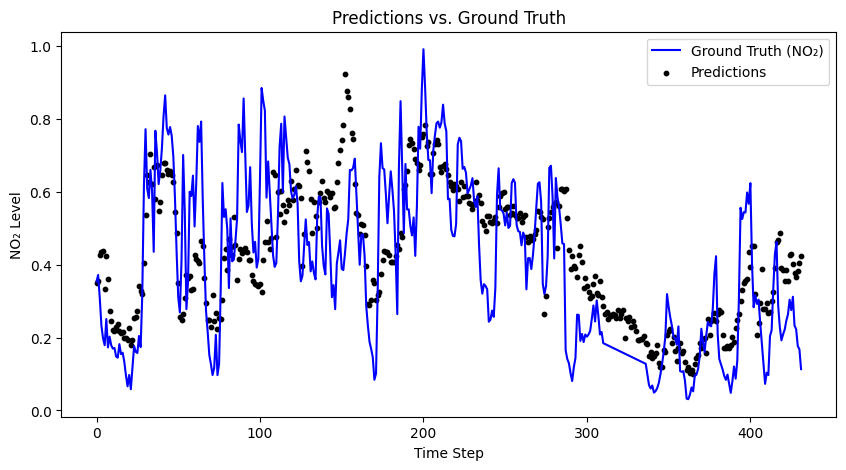

In [31]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
